# Sparse Score Fusion for Classifying Mate Pairs of Images

##  Challenge MDI343 2017-2018

## Introduction

#### Authors:  Umut Şimşekli & Stéphane Gentric

The topic of this challenge will be determining if two images belong to the same person or not. Conventionally, in order to solve this task, one typically builds an algorithm to provide a "score" for a given image pair. If the value of the score is high, it means that it is more probable that these images belong to the same person. Then, by using this score, one can determine if the images belong to the same person, by simply thresholding it.   

The goal of this challenge is to build a system for determining if two images belong to the same person or not by "fusing" multiple algorithms. In particular, for a given image pair, you will be provided the scores obtained from **14** different algorithms, each of which has a different computational complexity.   

Then the aim is to combine the scores of these algorithms (in a way that will be described in the sequel) in order to obtain a better classification accuracy. However, there will be a strict **computational budget**, such the running times of the algorithms that you combine **cannot exceed a certain time threshold**. For example, let $t_i$ denote the running time of algorithm $i$ in milliseconds ($i = 1,\dots,14$). Then, you will be given a threshold, $T$, such that the total computational time of the algorithms that you combine will not exceed $T$: 

$
\sum_{i\in C} t_i \leq T,
$

where $C \subset \{1,\dots,14\}$ is the set of algorithms that you choose to combine. The idea in such fusion is that "combining several fast algorithms might be better than using a single slow (possible more complex) algorithm". 

Before we describe how the fusion will be done, let us introduce the data:

**Training data:**

There will be $N= 2048853$ image pairs in the dataset. For a given image pair $n \in \{1,\dots,N\}$, we define $y_n = 1$ if this image pair belongs to the same person, or $y_n=0$ otherwise.

We then define a vector of scores for each image pair, $s_n \in \mathbb{R}_+^{14}$, such that $i$th component of $s_n$ will encode the score obtained by the $i$th algorithm, for the given image pair.  

**Test data:**

The test data contain $N_\text{test} = 170738$ image pairs. Similarly to the training data, each image pair contains a label and a vector of scores that are obtained from $14$ different algorithms. The test data will not be provided.


### Fusion Method 

In this challenge, you are expected to build a fusion system that is given as follows. Given a score vector $s \in \mathbb{R}_+^{14}$, we first define an extended vector $s'$, by appending a $1$ in the beginning of the original vector $s\in \mathbb{R}_+^{15}$: $s' = [1, s]$. Then we use the following fusion scheme in order to obtain the combined score $\hat{s}$: 

$
\hat{s} = s'^\top M s' 
$

where $M \in \mathbb{R}^{15 \times 15}$, is the "fusion matrix". This matrix will enable you to combine the scores of the different algorithms in a linear or a quadratic way. 


### The goal and the performance criterion

In this challenge, we will use an evaluation metric, which is commonly used in biometrics, namely the False Recognition Rate (FRR) at a fixed False Acceptance Rate (FAR). **The lower the better.**

The definitions of these quantities are as follows: (definitions from Webopedia)

**The false acceptance rate**, or **FAR**, is the measure of the likelihood that the biometric security system will incorrectly accept an access attempt by an unauthorized user. A system’s FAR typically is stated as the ratio of the number of false acceptances divided by the number of identification attempts.

**The false recognition rate**, or **FRR**, is the measure of the likelihood that the biometric security system will incorrectly reject an access attempt by an authorized user. A system’s FRR typically is stated as the ratio of the number of false recognitions divided by the number of identification attempts.

In this challenge, we will use the following evaluation scheme:

1) Given the scores, find a threshold that will give an FAR 0.01 %

2) Given the threshold, compute the FRR

The overall metric will be called **"the FRR at 0.01% FAR"**.


### Training Data

https://www.dropbox.com/s/6it6v6ifqkwuz98/train15_telecom.txt?dl=0


## Resolution

#### Author: Clément Probel

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy import special  # special.comb N choose k
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, StratifiedKFold
import itertools
from MDI343_challenge_utils import *

In [5]:
# Load the data
train_fname = 'train15_telecom.txt'
# The first column contains the labels, the rest of the columns contains the scores
train_data = np.loadtxt(train_fname, dtype=np.float)
train_data = train_data[~np.isin(train_data, [np.nan, np.inf, -np.inf]).any(1), :]  # Remove undesired values
# train_data = train_data[~np.any(train_data < 0, axis=1), :]  # Remove negative values

# Extract the labels
y_trn = train_data[:, 0].astype(int)

# Extract the score vectors
s_trn = train_data[:, 1:]

# Put a 1 in front of all the scores (see the "Fusion method" section above)
s_trn_1 = np.hstack([np.ones((s_trn.shape[0], 1)), s_trn])


This challenge is a binary classification problem. Before explaning the strategy, this is interesting to see if we can get *a priori* information about the best algorithms (first, without checking the computation time constraint).

## Exploratory Analysis

In [6]:
df = pd.DataFrame(train_data)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.0,4056.64,4329.06,4258.26,4487.92,4438.95,4624.01,4295.81,4516.67,5566.92,5365.55,3534.17,3877.52,4933.86,4970.20
1,0.0,2284.19,2448.09,2148.12,2246.95,2379.43,2581.86,2530.12,2782.97,2397.09,2606.08,1906.96,1856.95,2743.85,3048.56
2,0.0,2158.96,2263.43,2369.36,2567.98,2385.78,2590.60,2320.31,2499.47,2155.66,2258.41,1938.28,1910.30,2837.74,3158.75
3,0.0,2257.80,2410.03,2297.49,2467.10,2280.85,2443.30,2293.67,2461.65,2200.40,2325.69,1989.81,1996.23,2548.51,2806.69
4,0.0,2094.92,2164.81,1830.91,1723.67,2239.55,2383.45,2038.94,2076.11,2465.04,2697.64,1617.28,1317.34,2802.02,3117.27


In [7]:
df[0].value_counts()

0.0    1997772
1.0      51068
Name: 0, dtype: int64

The classes are very unbalanced.

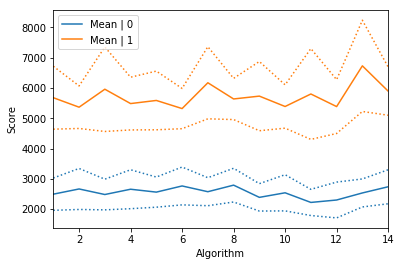

In [176]:
d = df.groupby(0).agg([np.mean, np.std]).stack().T
d[0.0]['mean'].plot(color='#1f77b4', label='Mean | 0')
(d[0.0]['mean'] - d[0.0]['std']).plot(color='#1f77b4', style=':', label='_nolegend_')
(d[0.0]['mean'] + d[0.0]['std']).plot(color='#1f77b4', style=':', label='_nolegend_')
d[1.0]['mean'].plot(color='#ff7f0e', label='Mean | 1')
(d[1.0]['mean'] - d[1.0]['std']).plot(color='#ff7f0e', style=':', label='_nolegend_')
(d[1.0]['mean'] + d[1.0]['std']).plot(color='#ff7f0e', style=':', label='_nolegend_')
plt.xlabel('Algorithm')
plt.ylabel('Score')
plt.legend()
plt.show()

On the plot above, we represent the average score $\pm$ one standard deviation of each algorithm, for each class. *On average*, the scores are very different for the two classes.

In [11]:
(d[1.0]['mean'] - d[0.0]['mean']).sort_values(ascending=False)

13    4194.758201
7     3595.974039
11    3578.942956
3     3475.354429
9     3341.337262
1     3183.542458
14    3157.328560
12    3083.393820
5     3025.532124
10    2848.162246
8     2844.366948
4     2827.034414
2     2698.782728
6     2554.207564
Name: mean, dtype: float64

The algorithms are ranked by the difference of their average score on the positives (class 1) and their average score on the negatives (class 0). Let's look at the density of the scores for each algorithm.

Text(0.5,0,'Score')

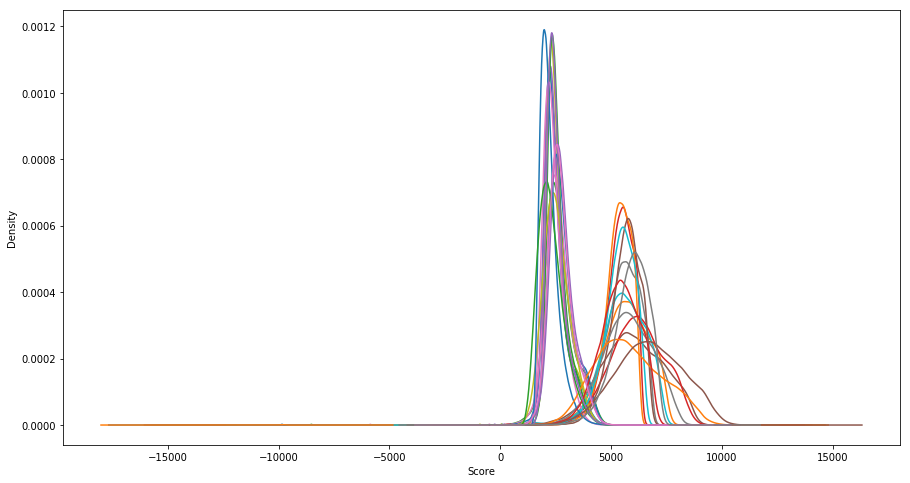

In [90]:
grp = df.groupby(0)
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
for i in range(1, 15):
    grp[i].plot.kde(ax=ax)
ax.set_xlabel('Score')

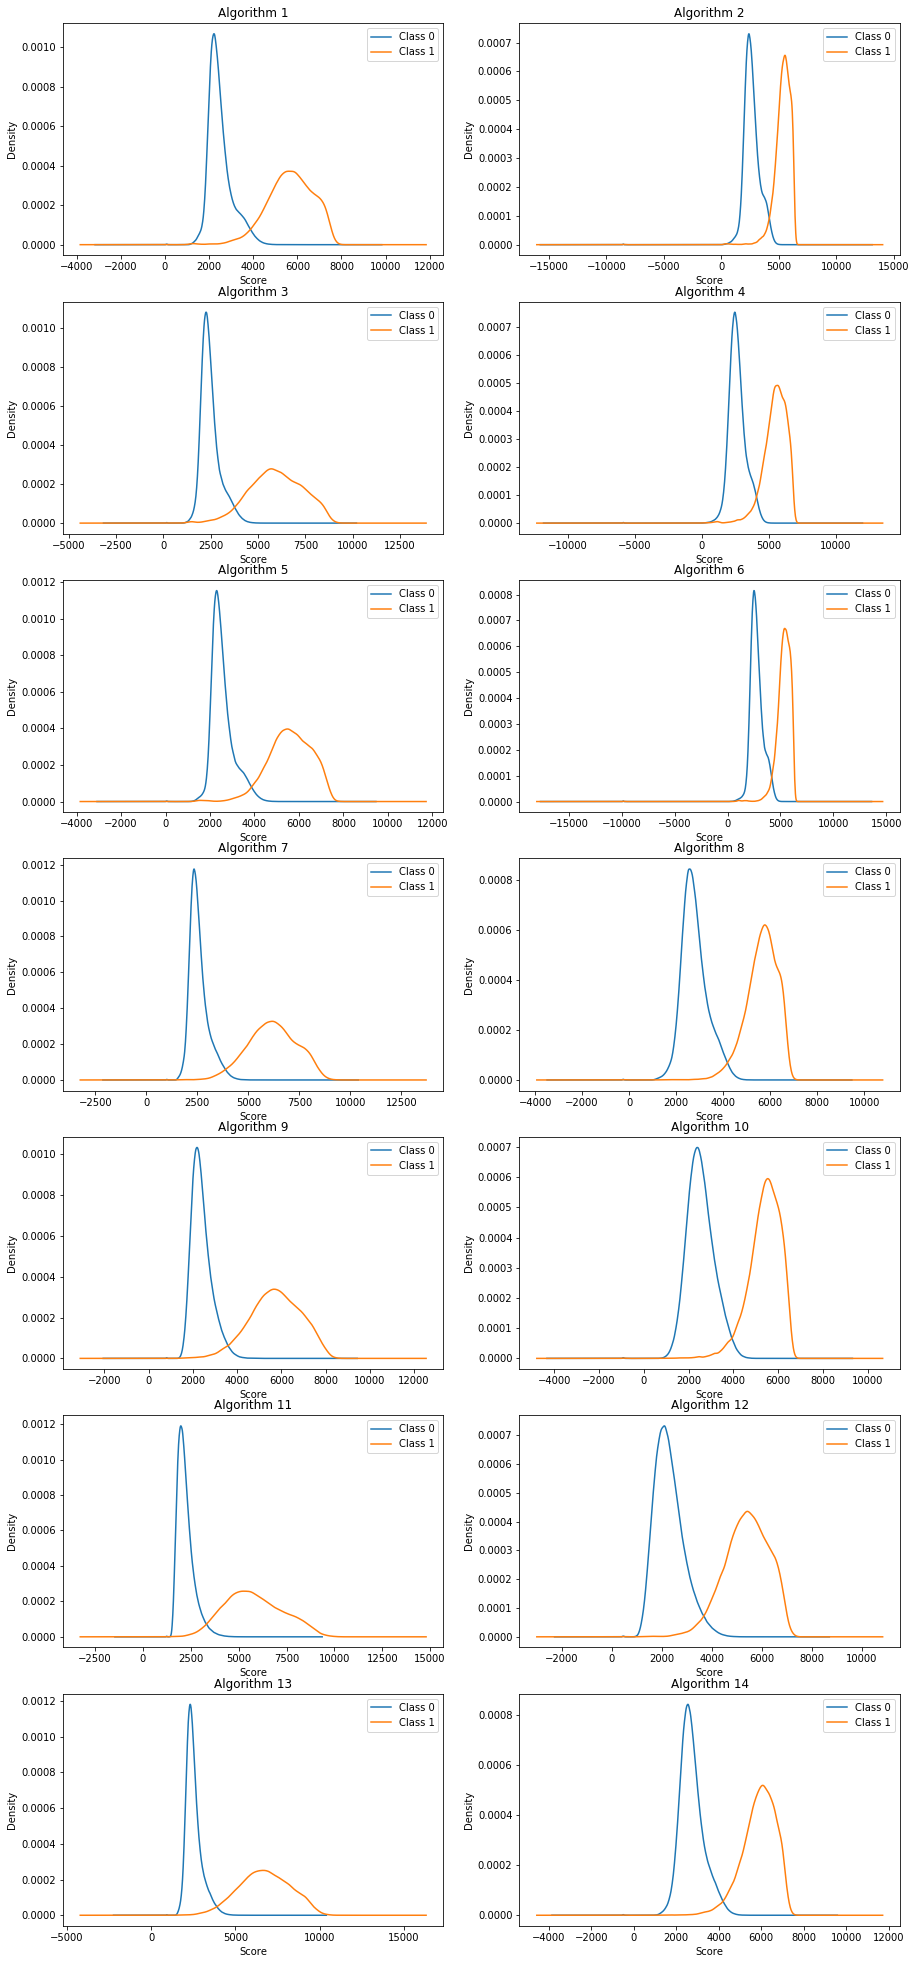

In [93]:
fig, axs = plt.subplots(7, 2, figsize=(15, 35))
grp = df.groupby(0)
for igrp in range(0, 14):
    i, j = igrp // 2, igrp % 2
    grp[igrp + 1].plot.kde(ax=axs[i][j])
    axs[i][j].set_xlabel('Score')    
    axs[i][j].set_title('Algorithm {}'.format(igrp + 1))     
    axs[i][j].legend(['Class 0', 'Class 1'])

We observe that the density functions overlap more or less given the algorithm. If the scores $X_0$ and $X_1$ were normally-distributed random variables, we could calculate the probability of one being bigger than the other ($X_0$ and $X_1$ are independent):

$\mathbb{P}[X_1>X_0]=1-\mathbb{P}[X_1-X_0\leq0]=1-\frac{1}{2}\left[1+\textrm{erf}\left(\frac{0-\mu}{\sigma\sqrt{2}}\right)\right]=\frac{1}{2}\left[1-\textrm{erf}\left(\frac{-(\mu_1-\mu_0)}{\sqrt{2(\sigma_0^2+\sigma_1^2)}}\right)\right]=\frac{1}{2}\textrm{erfc}\left(\frac{-(\mu_1-\mu_0)}{\sqrt{2(\sigma_0^2+\sigma_1^2)}}\right)$,

where $\textrm{erf}$ is the error function, defined as $\textrm{erf}(x)=\frac{2}{\sqrt{\pi}}\int_{0}^{x}e^{-t^2}\textrm{dt}$.

$\mathbb{P}[X_1>X_0]$ can be seen as a measure of separability. Below, the algorithms are ranked by decreasing separability.

In [25]:
(1 / 2 * special.erfc(-(d[1.0]['mean'] - d[0.0]['mean']) /
                      (np.sqrt(2 * (d[0.0]['std']**2 + d[1.0]['std']**2))))).sort_values(ascending=False)

14    0.999401
8     0.999395
10    0.998885
12    0.998082
7     0.997574
6     0.997460
5     0.997274
2     0.997172
1     0.996811
9     0.996730
13    0.996137
4     0.995518
3     0.990438
11    0.989109
dtype: float64

Finally, we deduce from the graph below that consecutive pairs of algorithms (1-2, 3-4, etc.) have highly correlated scores (it is possible that a pair corresponds to the same algorithm used with different parameters).

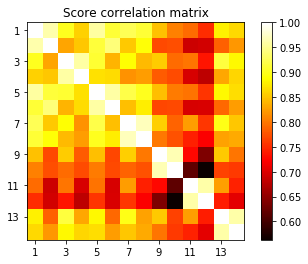

In [50]:
fig, ax = plt.subplots(1, 1)
plt.imshow(np.corrcoef(s_trn, rowvar=False), cmap='hot')
ax.set_xticks(range(0, 14, 2))
ax.set_yticks(range(0, 14, 2))
ax.set_xticklabels(range(1, 15, 2))
ax.set_yticklabels(range(1, 15, 2))
plt.title('Score correlation matrix')
plt.colorbar()
plt.show()

## Problem description

The motivation of this challenge is that a quadratic combination of some scores may give better results (when passed to the score function) than each single score. The combination information is contained in a matrix $M\in\mathbb{R}^{15 \times 15}$, called *fusion matrix*, which can be considered upper-triangular for symmetry reasons. If we develop $s'^\top M s'$, we easily see that the coefficients of M at indices:
- $(0,0)$ correspond to a constant,
- $(0,i)$ correspond to linear terms,
- $(i,j), i<j$ correspond to cross-terms,
- $(i,i)$ correspond to quadratic terms,

with $(i,j) \in [1,14]^2$.
 

Only a subset of all possible combinations of algorithms respects the computation time constraint. *compute_total_time*, *check_total_time* were given to check that a particular choice respects the time constraint.

*compute_eval* calculates the FRR at 0.01% FAR by thresholding a score vector *y_score*. *score_func*(*y_true*, *y_score*) is used as a custom scorer for this challenge. Most routines can be found in MDI343_challenge_utils.py.

The False Acceptance Rate (FAR) is the probability of accepting a non-authorized person (predict 1 given 0): $FAR = \frac{FP}{TN+FP}=1-\frac{TN}{TN+FP}=1-Specificity$.

The False Recognition Rate (FRR) is the probability of rejecting an authorized person (predict 0 given 1): $FRR = \frac{FN}{TP+FN}=1-\frac{TP}{TP+FN}=1-Recall$.

In [53]:
# Running time of each algorithm (in milliseconds)
alg_times = np.zeros((14,))
alg_times[0] = 163
alg_times[1] = 163
alg_times[2] = 190
alg_times[3] = 190
alg_times[4] = 206
alg_times[5] = 206
alg_times[6] = 120
alg_times[7] = 120
alg_times[8] = 83
alg_times[9] = 83
alg_times[10] = 83
alg_times[11] = 83
alg_times[12] = 170
alg_times[13] = 170

# Time constraint: The total duration of the algorithms cannot exceed 600 milliseconds
alg_time_thr = 600

alg_times.sum()

2030.0

In [54]:
# Check if the time constraint is satisfied:
def check_total_time(M):
    tot_dur = compute_total_time(M, alg_times)
    # print (tot_dur)

    if (tot_dur <= alg_time_thr):
        pass
        # print ("The total running time of the fusion is acceptable!")
    else:
        print ("The total running time of the fusion is NOT acceptable!")


## Preliminary results

A first simple thing we can do is test algorithms individually.

threshold: 5023.26 far: 9.961096661681113e-05 frr: 0.25303516879454846
threshold: 5029.01 far: 9.961096661681113e-05 frr: 0.25303516879454846
threshold: 5028.1 far: 9.961096661681113e-05 frr: 0.2558549385133547
threshold: 5032.16 far: 9.961096661681113e-05 frr: 0.2558549385133547
threshold: 4906.89 far: 9.961096661681113e-05 frr: 0.23106446306884937
threshold: 4952.24 far: 9.961096661681113e-05 frr: 0.23106446306884937
threshold: 5002.08 far: 9.961096661681113e-05 frr: 0.16534816323333595
threshold: 5015.17 far: 9.961096661681113e-05 frr: 0.16534816323333595
threshold: 4659.33 far: 9.961096661681113e-05 frr: 0.17404245319965536
threshold: 4782.7 far: 9.961096661681113e-05 frr: 0.17404245319965536
threshold: 4949.0 far: 9.961096661681113e-05 frr: 0.312994438787499
threshold: 4980.23 far: 9.961096661681113e-05 frr: 0.312994438787499
threshold: 5219.04 far: 9.961096661681113e-05 frr: 0.1629787734001723
threshold: 5154.23 far: 9.961096661681113e-05 frr: 0.1629787734001723


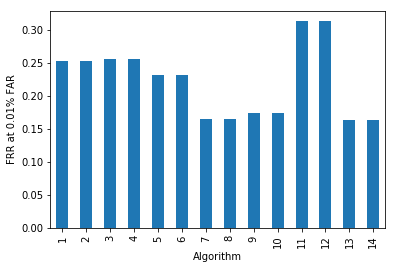

In [55]:
# Test algorithms individually
score_indiv = np.zeros((14,))
for m in range(1, 15):
    M = np.zeros((15, 15))
    M[0, m] = 1.0
    check_total_time(M)
    fuse = np.sum(np.multiply(s_trn_1, np.dot(s_trn_1, M.T)), axis=1)  # efficient
    score_indiv[m - 1] = score_func(y_trn, fuse)

pd.Series(score_indiv, index=range(1, 15)).plot.bar()
plt.xlabel('Algorithm')
plt.ylabel('FRR at 0.01% FAR')
plt.show()

A next simple thing we can do is sum the scores of the combined algorithms, for all combinations possible.

In [94]:
# List combinations of algorithms respecting time constraint
lst = np.array(list(map(list, itertools.product([0, 1], repeat=14))), dtype=bool)
alg_times_combined = np.dot(lst, alg_times)
lst_filtered = lst[(alg_times_combined > 0) & (alg_times_combined < alg_time_thr), :]
lst_filtered.shape

(1199, 14)

In [95]:
np.bincount(np.sum(lst_filtered, axis=1))

array([  0,  14,  91, 362, 593, 138,   1], dtype=int64)

There are around 1200 candidate combinations (14 1-algo, 91 2-algo, ..., 1 6-algo).

In [96]:
# Summing scores of all candidate combinations (sum and average are equivalent)

score_sum = np.zeros((lst_filtered.shape[0],))

for icombi, combi in enumerate(lst_filtered):
    M = np.zeros((15, 15))
    M[0, 1:][combi] = 1.0
    check_total_time(M)
    fuse = np.sum(np.multiply(s_trn_1, np.dot(s_trn_1, M.T)), axis=1)
    print("algorithms: {} ".format(np.where(combi)[0] + 1), end="")
    score_sum[icombi] = score_func(y_trn, fuse)

algorithms: [14] threshold: 5154.23 far: 9.961096661681113e-05 frr: 0.1629787734001723
algorithms: [13] threshold: 5219.04 far: 9.961096661681113e-05 frr: 0.1629787734001723
algorithms: [13 14] threshold: 10373.27 far: 9.961096661681113e-05 frr: 0.1629787734001723
algorithms: [12] threshold: 4980.23 far: 9.961096661681113e-05 frr: 0.312994438787499
algorithms: [12 14] threshold: 9556.16 far: 9.961096661681113e-05 frr: 0.1362888697423044
algorithms: [12 13] threshold: 9492.99 far: 9.961096661681113e-05 frr: 0.1260280410433148
algorithms: [12 13 14] threshold: 14531.68 far: 9.961096661681113e-05 frr: 0.12810370486410277
algorithms: [11] threshold: 4949.0 far: 9.961096661681113e-05 frr: 0.312994438787499
algorithms: [11 14] threshold: 9411.59 far: 9.961096661681113e-05 frr: 0.14482650583535678
algorithms: [11 13] threshold: 9331.74 far: 9.961096661681113e-05 frr: 0.12968982533093132
algorithms: [11 13 14] threshold: 14301.06 far: 9.961096661681113e-05 frr: 0.1253426803477716
algorithms: [

algorithms: [ 8 10 11 14] threshold: 18165.73 far: 9.961096661681113e-05 frr: 0.08574841387953318
algorithms: [ 8 10 11 13] threshold: 18115.21 far: 9.961096661681113e-05 frr: 0.08674708232161041
algorithms: [ 8 10 11 12] threshold: 18162.82 far: 9.961096661681113e-05 frr: 0.12166131432599671
algorithms: [ 8 10 11 12 14] threshold: 22770.92 far: 9.961096661681113e-05 frr: 0.10031722409336571
algorithms: [ 8 10 11 12 13] threshold: 22667.670000000002 far: 9.961096661681113e-05 frr: 0.09728205529881727
algorithms: [8 9] threshold: 9253.560000000001 far: 9.961096661681113e-05 frr: 0.11580637581264197
algorithms: [ 8  9 14] threshold: 14037.59 far: 9.961096661681113e-05 frr: 0.10061095010574136
algorithms: [ 8  9 13] threshold: 13988.05 far: 9.961096661681113e-05 frr: 0.09976893553693116
algorithms: [ 8  9 13 14] threshold: 19011.8 far: 9.961096661681113e-05 frr: 0.10593718179681992
algorithms: [ 8  9 12] threshold: 13383.95 far: 9.961096661681113e-05 frr: 0.08917521735724916
algorithms: [

algorithms: [ 7  8 12] threshold: 14273.58 far: 9.961096661681113e-05 frr: 0.13151092660766037
algorithms: [ 7  8 12 14] threshold: 18951.809999999998 far: 9.961096661681113e-05 frr: 0.11002976423592073
algorithms: [ 7  8 12 13] threshold: 18859.440000000002 far: 9.961096661681113e-05 frr: 0.10589801832850317
algorithms: [ 7  8 11] threshold: 14063.3 far: 9.961096661681113e-05 frr: 0.1302185321532075
algorithms: [ 7  8 11 14] threshold: 18743.75 far: 9.961096661681113e-05 frr: 0.10957938435027806
algorithms: [ 7  8 11 13] threshold: 18668.49 far: 9.961096661681113e-05 frr: 0.10670086942899663
algorithms: [ 7  8 11 12] threshold: 18709.399999999998 far: 9.961096661681113e-05 frr: 0.1424179525338764
algorithms: [ 7  8 11 12 14] threshold: 23372.65 far: 9.961096661681113e-05 frr: 0.12054515547896921
algorithms: [ 7  8 11 12 13] threshold: 23240.02 far: 9.961096661681113e-05 frr: 0.11369154852353724
algorithms: [ 7  8 10] threshold: 14257.02 far: 9.961096661681113e-05 frr: 0.12001644865669

algorithms: [ 6  8 11 12] threshold: 18652.94 far: 9.961096661681113e-05 frr: 0.15483277199028747
algorithms: [ 6  8 10] threshold: 14105.84 far: 9.961096661681113e-05 frr: 0.11590428448343386
algorithms: [ 6  8 10 14] threshold: 18897.85 far: 9.961096661681113e-05 frr: 0.10352862849533954
algorithms: [ 6  8 10 13] threshold: 18872.390000000003 far: 9.961096661681113e-05 frr: 0.10464478734236704
algorithms: [ 6  8 10 12] threshold: 18303.93 far: 9.961096661681113e-05 frr: 0.09855486801911177
algorithms: [ 6  8 10 11] threshold: 18066.29 far: 9.961096661681113e-05 frr: 0.0977715986527767
algorithms: [ 6  8 10 11 12] threshold: 22670.79 far: 9.961096661681113e-05 frr: 0.11218375499334221
algorithms: [6 8 9] threshold: 13887.48 far: 9.961096661681113e-05 frr: 0.11337824077700322
algorithms: [ 6  8  9 14] threshold: 18680.829999999998 far: 9.961096661681113e-05 frr: 0.10252996005326231
algorithms: [ 6  8  9 13] threshold: 18680.489999999998 far: 9.961096661681113e-05 frr: 0.103587373697814

algorithms: [ 5  9 10 11 12] threshold: 21906.21 far: 9.961096661681113e-05 frr: 0.10149212814286833
algorithms: [5 8] threshold: 9649.77 far: 9.961096661681113e-05 frr: 0.156575546330383
algorithms: [ 5  8 14] threshold: 14496.599999999999 far: 9.961096661681113e-05 frr: 0.12921986371113026
algorithms: [ 5  8 13] threshold: 14442.419999999998 far: 9.961096661681113e-05 frr: 0.124324430171536
algorithms: [ 5  8 12] threshold: 13920.51 far: 9.961096661681113e-05 frr: 0.12677214694133312
algorithms: [ 5  8 12 14] threshold: 18721.819999999996 far: 9.961096661681113e-05 frr: 0.11175295684185792
algorithms: [ 5  8 12 13] threshold: 18641.53 far: 9.961096661681113e-05 frr: 0.10738623012453984
algorithms: [ 5  8 11] threshold: 13735.25 far: 9.961096661681113e-05 frr: 0.12898488290122972
algorithms: [ 5  8 11 14] threshold: 18503.34 far: 9.961096661681113e-05 frr: 0.11163546643690765
algorithms: [ 5  8 11 13] threshold: 18432.33 far: 9.961096661681113e-05 frr: 0.10807159082008302
algorithms: 

algorithms: [ 4 11 12 13] threshold: 18564.129999999997 far: 9.961096661681113e-05 frr: 0.13748335552596538
algorithms: [ 4 10] threshold: 9479.16 far: 9.961096661681113e-05 frr: 0.15831832067047857
algorithms: [ 4 10 14] threshold: 14320.23 far: 9.961096661681113e-05 frr: 0.1292002819769719
algorithms: [ 4 10 13] threshold: 14318.85 far: 9.961096661681113e-05 frr: 0.12874990209132922
algorithms: [ 4 10 12] threshold: 13625.27 far: 9.961096661681113e-05 frr: 0.11696169812798621
algorithms: [ 4 10 12 14] threshold: 18429.18 far: 9.961096661681113e-05 frr: 0.10499725855721782
algorithms: [ 4 10 12 13] threshold: 18384.61 far: 9.961096661681113e-05 frr: 0.10348946502702279
algorithms: [ 4 10 11] threshold: 13432.38 far: 9.961096661681113e-05 frr: 0.1175687318868959
algorithms: [ 4 10 11 14] threshold: 18204.19 far: 9.961096661681113e-05 frr: 0.10392026317850708
algorithms: [ 4 10 11 13] threshold: 18136.03 far: 9.961096661681113e-05 frr: 0.1011788203963343
algorithms: [ 4 10 11 12] thresh

algorithms: [ 4  7  8 10 12] threshold: 23077.29 far: 9.961096661681113e-05 frr: 0.1064658886190961
algorithms: [ 4  7  8 10 11] threshold: 22857.0 far: 9.961096661681113e-05 frr: 0.10591760006266154
algorithms: [4 7 8 9] threshold: 18689.89 far: 9.961096661681113e-05 frr: 0.11950732356857523
algorithms: [ 4  7  8  9 12] threshold: 22789.489999999998 far: 9.961096661681113e-05 frr: 0.1015117098770267
algorithms: [ 4  7  8  9 11] threshold: 22570.17 far: 9.961096661681113e-05 frr: 0.10045429623247434
algorithms: [ 4  7  8  9 10] threshold: 23192.480000000003 far: 9.961096661681113e-05 frr: 0.11539515939531605
algorithms: [4 6] threshold: 9818.439999999999 far: 9.961096661681113e-05 frr: 0.21316675804809274
algorithms: [ 4  6 14] threshold: 14711.8 far: 9.961096661681113e-05 frr: 0.16372287929819065
algorithms: [ 4  6 13] threshold: 14682.150000000001 far: 9.961096661681113e-05 frr: 0.15442155557296156
algorithms: [ 4  6 12] threshold: 14011.11 far: 9.961096661681113e-05 frr: 0.150524790

algorithms: [ 3  9 11 12] threshold: 17636.11 far: 9.961096661681113e-05 frr: 0.12289496357797447
algorithms: [ 3  9 10] threshold: 13856.39 far: 9.961096661681113e-05 frr: 0.14968277590663429
algorithms: [ 3  9 10 14] threshold: 18637.77 far: 9.961096661681113e-05 frr: 0.12900446463538812
algorithms: [ 3  9 10 13] threshold: 18566.41 far: 9.961096661681113e-05 frr: 0.12452024751311976
algorithms: [ 3  9 10 12] threshold: 17784.299999999996 far: 9.961096661681113e-05 frr: 0.11061721626067204
algorithms: [ 3  9 10 11] threshold: 17503.14 far: 9.961096661681113e-05 frr: 0.10593718179681992
algorithms: [ 3  9 10 11 12] threshold: 21930.44 far: 9.961096661681113e-05 frr: 0.10717083104879768
algorithms: [3 8] threshold: 9685.36 far: 9.961096661681113e-05 frr: 0.17073314012688964
algorithms: [ 3  8 14] threshold: 14550.89 far: 9.961096661681113e-05 frr: 0.1414584475601159
algorithms: [ 3  8 13] threshold: 14555.64 far: 9.961096661681113e-05 frr: 0.13940236547348633
algorithms: [ 3  8 12] thr

algorithms: [ 2 10 11 12 14] threshold: 22809.050000000003 far: 9.961096661681113e-05 frr: 0.11106759614631471
algorithms: [ 2 10 11 12 13] threshold: 22700.14 far: 9.961096661681113e-05 frr: 0.10621132607503721
algorithms: [2 9] threshold: 9276.7 far: 9.961096661681113e-05 frr: 0.14092974073783973
algorithms: [ 2  9 14] threshold: 14068.720000000001 far: 9.961096661681113e-05 frr: 0.11590428448343386
algorithms: [ 2  9 13] threshold: 14035.880000000001 far: 9.961096661681113e-05 frr: 0.11502310644630688
algorithms: [ 2  9 13 14] threshold: 19106.99 far: 9.961096661681113e-05 frr: 0.11985979478342602
algorithms: [ 2  9 12] threshold: 13382.52 far: 9.961096661681113e-05 frr: 0.10268661392652934
algorithms: [ 2  9 12 14] threshold: 18134.95 far: 9.961096661681113e-05 frr: 0.09197540534189708
algorithms: [ 2  9 12 13] threshold: 18078.35 far: 9.961096661681113e-05 frr: 0.09242578522753975
algorithms: [ 2  9 11] threshold: 13173.01 far: 9.961096661681113e-05 frr: 0.10274535912900447
algori

algorithms: [ 2  7  8 10 12] threshold: 23156.19 far: 9.961096661681113e-05 frr: 0.10636797994830423
algorithms: [ 2  7  8 10 11] threshold: 22909.230000000003 far: 9.961096661681113e-05 frr: 0.10409649878593248
algorithms: [2 7 8 9] threshold: 18773.46 far: 9.961096661681113e-05 frr: 0.11927234275867471
algorithms: [ 2  7  8  9 12] threshold: 22894.890000000003 far: 9.961096661681113e-05 frr: 0.10247121485078718
algorithms: [ 2  7  8  9 11] threshold: 22668.47 far: 9.961096661681113e-05 frr: 0.10159003681366022
algorithms: [ 2  7  8  9 10] threshold: 23266.77 far: 9.961096661681113e-05 frr: 0.11445523615571394
algorithms: [2 6] threshold: 9888.939999999999 far: 9.961096661681113e-05 frr: 0.2200399467376831
algorithms: [ 2  6 14] threshold: 14716.7 far: 9.961096661681113e-05 frr: 0.15594893083731495
algorithms: [ 2  6 13] threshold: 14701.430000000002 far: 9.961096661681113e-05 frr: 0.14923239602099161
algorithms: [ 2  6 12] threshold: 14108.25 far: 9.961096661681113e-05 frr: 0.1523067

algorithms: [ 1  8 11 12] threshold: 18544.25 far: 9.961096661681113e-05 frr: 0.1519738388031644
algorithms: [ 1  8 10] threshold: 14099.939999999999 far: 9.961096661681113e-05 frr: 0.12706587295370877
algorithms: [ 1  8 10 14] threshold: 18900.11 far: 9.961096661681113e-05 frr: 0.11312367823294431
algorithms: [ 1  8 10 13] threshold: 18877.379999999997 far: 9.961096661681113e-05 frr: 0.11331949557452808
algorithms: [ 1  8 10 12] threshold: 18236.79 far: 9.961096661681113e-05 frr: 0.10419440745672437
algorithms: [ 1  8 10 11] threshold: 18004.95 far: 9.961096661681113e-05 frr: 0.10301950340722174
algorithms: [ 1  8 10 11 12] threshold: 22535.32 far: 9.961096661681113e-05 frr: 0.11136132215869038
algorithms: [1 8 9] threshold: 13876.28 far: 9.961096661681113e-05 frr: 0.12258165583144043
algorithms: [ 1  8  9 14] threshold: 18676.64 far: 9.961096661681113e-05 frr: 0.1104018171849299
algorithms: [ 1  8  9 13] threshold: 18641.04 far: 9.961096661681113e-05 frr: 0.11006892770423748
algorith

algorithms: [ 1  5 10] threshold: 14068.920000000002 far: 9.961096661681113e-05 frr: 0.15397117568731886
algorithms: [ 1  5 10 12] threshold: 18124.71 far: 9.961096661681113e-05 frr: 0.11903736194877418
algorithms: [ 1  5 10 11] threshold: 17893.17 far: 9.961096661681113e-05 frr: 0.1168050442547192
algorithms: [1 5 9] threshold: 13836.73 far: 9.961096661681113e-05 frr: 0.1449635779744654
algorithms: [ 1  5  9 12] threshold: 17888.94 far: 9.961096661681113e-05 frr: 0.1144160726873972
algorithms: [ 1  5  9 11] threshold: 17606.94 far: 9.961096661681113e-05 frr: 0.10999060076760397
algorithms: [ 1  5  9 10] threshold: 18371.85 far: 9.961096661681113e-05 frr: 0.1359363985274536
algorithms: [1 5 8] threshold: 14484.490000000002 far: 9.961096661681113e-05 frr: 0.16900994752095247
algorithms: [ 1  5  8 12] threshold: 18678.7 far: 9.961096661681113e-05 frr: 0.1384036970314091
algorithms: [ 1  5  8 11] threshold: 18464.53 far: 9.961096661681113e-05 frr: 0.13640636014725463
algorithms: [ 1  5  8

In [109]:
score_sum.min()

0.08241951907260907

In [120]:
np.where(lst_filtered[score_sum.argmin()])[0] + 1

array([ 8,  9, 10, 11, 14], dtype=int64)

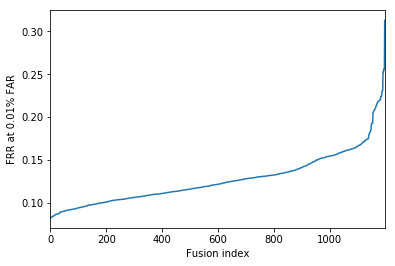

In [111]:
pd.Series(score_sum).sort_values().reset_index(drop=True).plot()
plt.xlabel('Fusion index')
plt.ylabel('FRR at 0.01% FAR')
plt.show()

## Classification problem

The coefficients of $M$ can be obtained by solving a classification problem, which takes the matrix of scores as input and predicts a label (0 or 1). 
If we fit a linear classifier which separates positives from negatives, the FRR will be zero (which is great).

The coefficients of $M$ can be obtained directly from the coefficients of a linear classifier. Linear classifiers include: logistic regression, perceptron, linear SVM, etc.

To account for quadratic fusion, polynomial and interaction features are added to the input matrix.

The fused score $s'^\top M s'$ is nothing more than a confidence score, i.e. a signed distance to the hyperplane. $s'^\top M s'$ is just a 2-D notation of this distance. The coefficients of the hyperplane can be found through linear classification and plugged back into $M$.

*construct_fusion_matrix* is a routine which builds the fusion matrix from a vector of coefficients.

For better score and smaller computation time, the training data is scaled to zero mean and unit variance. As the test data is not scaled, this has to be taken into account while building matrix $M$: new coefficients $c$ must be derived from the coefficients $c'$ obtained from the scaled data $X'$. We look for $c$ such that $\langle c,X\rangle=\langle c',X'\rangle$ where $X$ is the raw data:
$\langle c',X'\rangle=c_0'+\sum_{i=1}^{d}c_i'\frac{X_i-\mu_i}{\sigma_i}=\left(c_0'-\sum_{i=1}^{d}c_i'\frac{\mu_i}{\sigma_i}\right)+\sum_{i=1}^{d}\left(\frac{c_i'}{\sigma_i}\right)X_i$, and the $c_i$'s appear. The *scaler* object is passed to *construct_fusion_matrix*.



### Examples

First, we fit a logistic regression on the whole training set and check that we obtain the same results from the classifier's decision function and matrix $M$.

In [60]:
scaler = StandardScaler()
clf = LogisticRegression(class_weight='balanced', fit_intercept=False)

s_trn_scaled = scaler.fit_transform(s_trn)
s_trn_scaled_1 = np.hstack([np.ones((s_trn_scaled.shape[0], 1)), s_trn_scaled])

clf.fit(s_trn_scaled_1, y_trn)
score_func(y_trn, clf.decision_function(s_trn_scaled_1))

threshold: 6.216785235432177 far: 9.961096661681113e-05 frr: 0.07638834495182893


0.07638834495182893

In [61]:
# Check
M = construct_fusion_matrix(clf.coef_, scaler=scaler)
fuse = np.sum(np.multiply(s_trn_1, np.dot(s_trn_1, M.T)), axis=1)
score_func(y_trn, fuse)

threshold: 6.216785235432178 far: 9.961096661681113e-05 frr: 0.07638834495182893


0.07638834495182893

Then, this also works when we isolate a subset of columns (algorithms) and add the polynomial features.

In [72]:
col = np.array([8, 9, 10, 11, 14]) - 1  # algorithm combination (0-13)
poly = PolynomialFeatures(degree=2, include_bias=False)

s_trn_poly = poly.fit_transform(s_trn[:, col])
s_trn_poly_scaled = scaler.fit_transform(s_trn_poly)
s_trn_poly_scaled_1 = np.hstack(
    [np.ones((s_trn_poly_scaled.shape[0], 1)), s_trn_poly_scaled])

clf.fit(s_trn_poly_scaled_1, y_trn)
score_func(y_trn, clf.decision_function(s_trn_poly_scaled_1))

threshold: 6.089091584299551 far: 9.961096661681113e-05 frr: 0.08226286519934205


0.08226286519934205

In [75]:
# Check
M = construct_fusion_matrix(clf.coef_, np.insert(
    col + 1, 0, 0), scaler=scaler, poly=True)
fuse = np.sum(np.multiply(s_trn_1, np.dot(s_trn_1, M.T)), axis=1)
score_func(y_trn, fuse)

threshold: 6.089091584299558 far: 9.961096661681113e-05 frr: 0.08226286519934205


0.08226286519934205

The strategy now is to apply a couple of linear classifiers to all (scaled) candidate combinations in order to identify the best combinations. Once we have, say a Top 20, we can submit results, modify hyperparameters, test new classifiers, and, more importantly, find the best hyperparameters of a family of classifiers by cross-validation.

For every candidate combination, we apply:
- Logistic regression with L2-penalty on scaled data (*s+LR*)
- Logistic regression with L2-penalty on polynomial, scaled data (*p+s+LR*)
- Perceptron with L1-penalty on polynomial, scaled data (*p+s+PER*)

We use *scikit-learn*. Class imbalance is taken into account via class_weight='balanced'. We fit no intercept as the data already contains a constant column.

As shown above, matrix $M$ is of no help in any calculation. It is only created afterwards, for submission purpose.


### Logistic regression with L2-penalty on scaled data

In [14]:
clf = LogisticRegression(class_weight='balanced', fit_intercept=False, tol=1e-7)

s_trn_scaled = scaler.fit_transform(s_trn)
s_trn_scaled_1 = np.hstack([np.ones((s_trn_scaled.shape[0], 1)), s_trn_scaled])

lst_filtered_1 = np.hstack([np.ones((lst_filtered.shape[0], 1), dtype=bool), lst_filtered])

score_lr = np.zeros((lst_filtered_1.shape[0],))

for icombi, combi in enumerate(lst_filtered_1):
    x_trn = s_trn_scaled_1[:, combi]
    clf.fit(x_trn, y_trn)
    print("algorithms: {} ".format(np.where(combi)[0][1:]), end="")
    score_lr[icombi] = score_func(y_trn, clf.decision_function(x_trn))

algorithms: [14] threshold: 4.205344229861824 far: 9.961096661681113e-05 frr: 0.1629787734001723
algorithms: [13] threshold: 5.134254987035799 far: 9.961096661681113e-05 frr: 0.1629787734001723
algorithms: [13 14] threshold: 6.64996550348795 far: 9.961096661681113e-05 frr: 0.1629787734001723
algorithms: [12] threshold: 5.330415678751364 far: 9.961096661681113e-05 frr: 0.312994438787499
algorithms: [12 14] threshold: 4.171767078259731 far: 9.961096661681113e-05 frr: 0.12800579619331087
algorithms: [12 13] threshold: 4.604887203409744 far: 9.961096661681113e-05 frr: 0.12573431503093915
algorithms: [12 13 14] threshold: 6.438865649027452 far: 9.961096661681113e-05 frr: 0.1297877340017232
algorithms: [11] threshold: 6.710268906755003 far: 9.961096661681113e-05 frr: 0.312994438787499
algorithms: [11 14] threshold: 4.607347739442669 far: 9.961096661681113e-05 frr: 0.1369546487036892
algorithms: [11 13] threshold: 4.953002549264879 far: 9.961096661681113e-05 frr: 0.12577347849925588
algorithm

algorithms: [ 8 10 13] threshold: 3.880895620680802 far: 9.961096661681113e-05 frr: 0.10499725855721782
algorithms: [ 8 10 13 14] threshold: 5.965756242311194 far: 9.961096661681113e-05 frr: 0.11752956841857914
algorithms: [ 8 10 12] threshold: 3.681959290128014 far: 9.961096661681113e-05 frr: 0.09401190569436829
algorithms: [ 8 10 12 14] threshold: 3.6434927050897086 far: 9.961096661681113e-05 frr: 0.08839194799091407
algorithms: [ 8 10 12 13] threshold: 3.8045716633708984 far: 9.961096661681113e-05 frr: 0.08770658729537088
algorithms: [ 8 10 11] threshold: 4.075538626315095 far: 9.961096661681113e-05 frr: 0.1037440275710817
algorithms: [ 8 10 11 14] threshold: 3.9846093657567057 far: 9.961096661681113e-05 frr: 0.09495182893397039
algorithms: [ 8 10 11 13] threshold: 4.1438414530685606 far: 9.961096661681113e-05 frr: 0.09273909297407379
algorithms: [ 8 10 11 12] threshold: 5.2592020348744875 far: 9.961096661681113e-05 frr: 0.12685047387796664
algorithms: [ 8 10 11 12 14] threshold: 5.

algorithms: [ 7  9 10 12] threshold: 5.167713423405374 far: 9.961096661681113e-05 frr: 0.08948852510378319
algorithms: [ 7  9 10 12 14] threshold: 5.283658218945672 far: 9.961096661681113e-05 frr: 0.08852902013002271
algorithms: [ 7  9 10 12 13] threshold: 5.331761458542557 far: 9.961096661681113e-05 frr: 0.08563092347458291
algorithms: [ 7  9 10 11] threshold: 5.291815762835098 far: 9.961096661681113e-05 frr: 0.08619879376517585
algorithms: [ 7  9 10 11 14] threshold: 5.373877314695984 far: 9.961096661681113e-05 frr: 0.08439727422260515
algorithms: [ 7  9 10 11 13] threshold: 5.385405756006661 far: 9.961096661681113e-05 frr: 0.08192997571864964
algorithms: [ 7  9 10 11 12] threshold: 5.601113310812645 far: 9.961096661681113e-05 frr: 0.0868254092582439
algorithms: [7 8] threshold: 6.510667739889621 far: 9.961096661681113e-05 frr: 0.16534816323333595
algorithms: [ 7  8 14] threshold: 6.131016292289196 far: 9.961096661681113e-05 frr: 0.13025769562152426
algorithms: [ 7  8 13] threshold: 

algorithms: [ 5 10 13] threshold: 4.31816230732943 far: 9.961096661681113e-05 frr: 0.12467690138638678
algorithms: [ 5 10 12] threshold: 3.8543876339374687 far: 9.961096661681113e-05 frr: 0.10658337902404637
algorithms: [ 5 10 12 14] threshold: 3.8008900366744025 far: 9.961096661681113e-05 frr: 0.09510848280723741
algorithms: [ 5 10 12 13] threshold: 4.08782233733908 far: 9.961096661681113e-05 frr: 0.09595049737604762
algorithms: [ 5 10 11] threshold: 4.326681865316855 far: 9.961096661681113e-05 frr: 0.11674629905224407
algorithms: [ 5 10 11 14] threshold: 4.197158706792864 far: 9.961096661681113e-05 frr: 0.10362653716613143
algorithms: [ 5 10 11 13] threshold: 4.459239715221155 far: 9.961096661681113e-05 frr: 0.10059136837158299
algorithms: [ 5 10 11 12] threshold: 5.426210657716426 far: 9.961096661681113e-05 frr: 0.1375616824625989
algorithms: [5 9] threshold: 4.009438869018326 far: 9.961096661681113e-05 frr: 0.1369546487036892
algorithms: [ 5  9 14] threshold: 3.875814798841898 far:

algorithms: [ 4  8  9 10] threshold: 5.489317969225407 far: 9.961096661681113e-05 frr: 0.12189629513589724
algorithms: [ 4  8  9 10 12] threshold: 5.081266709451047 far: 9.961096661681113e-05 frr: 0.0937573431503094
algorithms: [ 4  8  9 10 11] threshold: 5.202399327602473 far: 9.961096661681113e-05 frr: 0.08823529411764706
algorithms: [4 7] threshold: 5.030678797485634 far: 9.961096661681113e-05 frr: 0.16824625988877576
algorithms: [ 4  7 14] threshold: 4.876187779641051 far: 9.961096661681113e-05 frr: 0.13460484060468395
algorithms: [ 4  7 13] threshold: 5.3717563653574985 far: 9.961096661681113e-05 frr: 0.12596929584083966
algorithms: [ 4  7 12] threshold: 4.747855235697833 far: 9.961096661681113e-05 frr: 0.13630845147646276
algorithms: [ 4  7 12 14] threshold: 4.736235698469988 far: 9.961096661681113e-05 frr: 0.11702044333046134
algorithms: [ 4  7 12 13] threshold: 5.150711188477207 far: 9.961096661681113e-05 frr: 0.11087177880473095
algorithms: [ 4  7 11] threshold: 5.050694674841

algorithms: [ 4  5  8 10] threshold: 3.9583925354117313 far: 9.961096661681113e-05 frr: 0.12256207409728205
algorithms: [4 5 8 9] threshold: 4.236648538345536 far: 9.961096661681113e-05 frr: 0.12001644865669303
algorithms: [4 5 7] threshold: 4.964154372955108 far: 9.961096661681113e-05 frr: 0.1626458839194799
algorithms: [ 4  5  7 12] threshold: 4.6422100367074925 far: 9.961096661681113e-05 frr: 0.13194172475914467
algorithms: [ 4  5  7 11] threshold: 4.944507660729294 far: 9.961096661681113e-05 frr: 0.1311584553928096
algorithms: [ 4  5  7 10] threshold: 4.456226149547509 far: 9.961096661681113e-05 frr: 0.12502937260123756
algorithms: [4 5 7 9] threshold: 4.6743358365887575 far: 9.961096661681113e-05 frr: 0.11733375107699538
algorithms: [3] threshold: 4.25463551671821 far: 9.961096661681113e-05 frr: 0.2558549385133547
algorithms: [ 3 14] threshold: 4.309486768525782 far: 9.961096661681113e-05 frr: 0.17202553458134254
algorithms: [ 3 13] threshold: 5.418640666311058 far: 9.961096661681

algorithms: [ 3  7 11 14] threshold: 4.586314857830442 far: 9.961096661681113e-05 frr: 0.11598261142006736
algorithms: [ 3  7 11 13] threshold: 5.053337131482565 far: 9.961096661681113e-05 frr: 0.11281037048641028
algorithms: [ 3  7 11 12] threshold: 5.765448733355727 far: 9.961096661681113e-05 frr: 0.14177175530664995
algorithms: [ 3  7 10] threshold: 4.274590183818485 far: 9.961096661681113e-05 frr: 0.12571473329678076
algorithms: [ 3  7 10 14] threshold: 4.153994800208692 far: 9.961096661681113e-05 frr: 0.11206626458839195
algorithms: [ 3  7 10 13] threshold: 4.5667818260852 far: 9.961096661681113e-05 frr: 0.10979478342602021
algorithms: [ 3  7 10 12] threshold: 3.9695754870595747 far: 9.961096661681113e-05 frr: 0.09788908905772695
algorithms: [ 3  7 10 11] threshold: 4.352143793734435 far: 9.961096661681113e-05 frr: 0.10431189786167464
algorithms: [ 3  7 10 11 12] threshold: 5.340615134578668 far: 9.961096661681113e-05 frr: 0.11946816010025847
algorithms: [3 7 9] threshold: 4.40471

algorithms: [ 3  4 12] threshold: 11.131387466107885 far: 9.961096661681113e-05 frr: 0.5000391634683168
algorithms: [ 3  4 11] threshold: 11.458376904596154 far: 9.961096661681113e-05 frr: 0.43518445993577193
algorithms: [ 3  4 11 12] threshold: 11.499181358913846 far: 9.961096661681113e-05 frr: 0.4252369389833164
algorithms: [ 3  4 10] threshold: 10.095288597231658 far: 9.961096661681113e-05 frr: 0.48306179995300386
algorithms: [ 3  4 10 12] threshold: 8.625853419995401 far: 9.961096661681113e-05 frr: 0.330755071669147
algorithms: [ 3  4 10 11] threshold: 7.724068792208351 far: 9.961096661681113e-05 frr: 0.2313190256129083
algorithms: [3 4 9] threshold: 13.085708527164147 far: 9.961096661681113e-05 frr: 0.5457625127281273
algorithms: [ 3  4  9 12] threshold: 9.078012084611776 far: 9.961096661681113e-05 frr: 0.29799483042218217
algorithms: [ 3  4  9 11] threshold: 8.553598490305363 far: 9.961096661681113e-05 frr: 0.23188689590350123
algorithms: [ 3  4  9 10] threshold: 14.8279187906743

algorithms: [ 2  8 12 13] threshold: 4.767504243220753 far: 9.961096661681113e-05 frr: 0.11320200516957782
algorithms: [ 2  8 11] threshold: 4.67750589672899 far: 9.961096661681113e-05 frr: 0.1448852510378319
algorithms: [ 2  8 11 14] threshold: 4.740706872250576 far: 9.961096661681113e-05 frr: 0.12109344403540377
algorithms: [ 2  8 11 13] threshold: 5.072811186624238 far: 9.961096661681113e-05 frr: 0.11541474112947443
algorithms: [ 2  8 11 12] threshold: 5.64453292648549 far: 9.961096661681113e-05 frr: 0.1617842876165113
algorithms: [ 2  8 10] threshold: 3.8747646182656497 far: 9.961096661681113e-05 frr: 0.11966397744184225
algorithms: [ 2  8 10 14] threshold: 4.134186418818251 far: 9.961096661681113e-05 frr: 0.11196835591760006
algorithms: [ 2  8 10 13] threshold: 4.475329161166924 far: 9.961096661681113e-05 frr: 0.10961854781859481
algorithms: [ 2  8 10 12] threshold: 4.070835830244718 far: 9.961096661681113e-05 frr: 0.10012140675178194
algorithms: [ 2  8 10 11] threshold: 4.4668723

algorithms: [ 2  6  7 11] threshold: 5.202621697780703 far: 9.961096661681113e-05 frr: 0.13511396569280176
algorithms: [ 2  6  7 10] threshold: 4.581141683488221 far: 9.961096661681113e-05 frr: 0.12630218532153206
algorithms: [2 6 7 9] threshold: 4.762579942019764 far: 9.961096661681113e-05 frr: 0.11811702044333046
algorithms: [2 5] threshold: 4.492456957981988 far: 9.961096661681113e-05 frr: 0.24412547975248688
algorithms: [ 2  5 14] threshold: 4.412559221829496 far: 9.961096661681113e-05 frr: 0.1547152815853372
algorithms: [ 2  5 13] threshold: 5.094339348866615 far: 9.961096661681113e-05 frr: 0.1507793530195034
algorithms: [ 2  5 12] threshold: 4.676088984797592 far: 9.961096661681113e-05 frr: 0.17100728440510693
algorithms: [ 2  5 11] threshold: 5.233459352650542 far: 9.961096661681113e-05 frr: 0.17523693898331635
algorithms: [ 2  5 11 12] threshold: 6.178008979221968 far: 9.961096661681113e-05 frr: 0.1868880708075507
algorithms: [ 2  5 10] threshold: 3.9163730244044235 far: 9.9610

algorithms: [2 3 4] threshold: 7.777459495500658 far: 9.961096661681113e-05 frr: 0.3413683715829874
algorithms: [1] threshold: 4.259254049974309 far: 9.961096661681113e-05 frr: 0.25303516879454846
algorithms: [ 1 14] threshold: 4.115436712785712 far: 9.961096661681113e-05 frr: 0.1555572961541474
algorithms: [ 1 13] threshold: 4.977394001211825 far: 9.961096661681113e-05 frr: 0.15900368136602178
algorithms: [ 1 13 14] threshold: 6.49616407743053 far: 9.961096661681113e-05 frr: 0.1588274457585964
algorithms: [ 1 12] threshold: 4.357842739114769 far: 9.961096661681113e-05 frr: 0.17345500117490406
algorithms: [ 1 12 14] threshold: 4.18893125415848 far: 9.961096661681113e-05 frr: 0.12912195504033838
algorithms: [ 1 12 13] threshold: 4.715182303527234 far: 9.961096661681113e-05 frr: 0.12931777238192213
algorithms: [ 1 12 13 14] threshold: 6.436796787691797 far: 9.961096661681113e-05 frr: 0.12998355134330697
algorithms: [ 1 11] threshold: 5.021685806565845 far: 9.961096661681113e-05 frr: 0.18

algorithms: [ 1  7 14] threshold: 4.506382351340744 far: 9.961096661681113e-05 frr: 0.12775123364925198
algorithms: [ 1  7 13] threshold: 4.940676347388322 far: 9.961096661681113e-05 frr: 0.12336492519777552
algorithms: [ 1  7 12] threshold: 4.614836969349609 far: 9.961096661681113e-05 frr: 0.132685830657163
algorithms: [ 1  7 12 14] threshold: 4.387885949644964 far: 9.961096661681113e-05 frr: 0.11286911568888541
algorithms: [ 1  7 12 13] threshold: 4.799315709286121 far: 9.961096661681113e-05 frr: 0.11190961071512494
algorithms: [ 1  7 11] threshold: 4.933769567437575 far: 9.961096661681113e-05 frr: 0.1332928644160727
algorithms: [ 1  7 11 14] threshold: 4.6637395221752325 far: 9.961096661681113e-05 frr: 0.11459230829482259
algorithms: [ 1  7 11 13] threshold: 5.0654457407839555 far: 9.961096661681113e-05 frr: 0.11124383175374011
algorithms: [ 1  7 11 12] threshold: 5.784629246795532 far: 9.961096661681113e-05 frr: 0.1420654813190256
algorithms: [ 1  7 10] threshold: 4.310412585383817

algorithms: [1 5 7] threshold: 4.929548083547798 far: 9.961096661681113e-05 frr: 0.16323333594423123
algorithms: [ 1  5  7 12] threshold: 4.594059538081213 far: 9.961096661681113e-05 frr: 0.1316675804809274
algorithms: [ 1  5  7 11] threshold: 4.913964875896049 far: 9.961096661681113e-05 frr: 0.13292081146706353
algorithms: [ 1  5  7 10] threshold: 4.317236278000529 far: 9.961096661681113e-05 frr: 0.12469648312054515
algorithms: [1 5 7 9] threshold: 4.45807135966389 far: 9.961096661681113e-05 frr: 0.11747082321610401
algorithms: [1 5 6] threshold: 40.824622423365454 far: 9.961096661681113e-05 frr: 0.9999216730633665
algorithms: [1 4] threshold: 4.222105670527868 far: 9.961096661681113e-05 frr: 0.2505482885564346
algorithms: [ 1  4 14] threshold: 4.612166622340597 far: 9.961096661681113e-05 frr: 0.172985039555103
algorithms: [ 1  4 13] threshold: 5.462351174596606 far: 9.961096661681113e-05 frr: 0.1610989269209681
algorithms: [ 1  4 12] threshold: 4.496555159242446 far: 9.96109666168111

algorithms: [ 1  2  9 11] threshold: 4.875986938361529 far: 9.961096661681113e-05 frr: 0.10703375890968904
algorithms: [ 1  2  9 11 12] threshold: 5.287067442212834 far: 9.961096661681113e-05 frr: 0.11073470666562231
algorithms: [ 1  2  9 10] threshold: 5.29568606704132 far: 9.961096661681113e-05 frr: 0.1448852510378319
algorithms: [ 1  2  9 10 12] threshold: 5.162633511131094 far: 9.961096661681113e-05 frr: 0.10227539750920342
algorithms: [ 1  2  9 10 11] threshold: 5.427565176422288 far: 9.961096661681113e-05 frr: 0.09794783426020208
algorithms: [1 2 8] threshold: 7.357910213448314 far: 9.961096661681113e-05 frr: 0.3639852745359129
algorithms: [ 1  2  8 12] threshold: 5.8189488040254265 far: 9.961096661681113e-05 frr: 0.2055102999921673
algorithms: [ 1  2  8 11] threshold: 4.779951565118018 far: 9.961096661681113e-05 frr: 0.13352784522597322
algorithms: [ 1  2  8 10] threshold: 4.846293901343413 far: 9.961096661681113e-05 frr: 0.1543628103704864
algorithms: [1 2 8 9] threshold: 4.204

In [15]:
score_lr.min()

0.08192997571864964

In [16]:
np.where(lst_filtered[score_lr.argmin()])[0] + 1

(array([ 0,  7,  9, 10, 11, 13], dtype=int64),)

### Logistic regression with L2-penalty on polynomial, scaled data

In [17]:
clf = LogisticRegression(class_weight='balanced',
                         fit_intercept=False, tol=1e-7)

score_poly_lr = np.zeros((lst_filtered.shape[0],))

for icombi, combi in enumerate(lst_filtered):
    x_trn = s_trn[:, combi]
    s_trn_poly = poly.fit_transform(x_trn)
    s_trn_poly_scaled = scaler.fit_transform(s_trn_poly)
    s_trn_poly_scaled_1 = np.hstack(
        [np.ones((s_trn_poly_scaled.shape[0], 1)), s_trn_poly_scaled])
    clf.fit(s_trn_poly_scaled_1, y_trn)
    print("algorithms: {} ".format(np.where(combi)[0] + 1), end="")
    score_poly_lr[icombi] = score_func(
        y_trn, clf.decision_function(s_trn_poly_scaled_1))

algorithms: [14] threshold: 5.906523466875299 far: 9.961096661681113e-05 frr: 0.1629787734001723
algorithms: [13] threshold: 6.697544870337431 far: 9.961096661681113e-05 frr: 0.1629787734001723
algorithms: [13 14] threshold: 5.857183676881869 far: 9.961096661681113e-05 frr: 0.1629787734001723
algorithms: [12] threshold: 6.859518585905066 far: 9.961096661681113e-05 frr: 0.312994438787499
algorithms: [12 14] threshold: 5.793415729952537 far: 9.961096661681113e-05 frr: 0.12332576172945876
algorithms: [12 13] threshold: 7.028990214948684 far: 9.961096661681113e-05 frr: 0.12452024751311976
algorithms: [12 13 14] threshold: 5.936002559953536 far: 9.961096661681113e-05 frr: 0.12322785305866688
algorithms: [11] threshold: 6.725207058455248 far: 9.961096661681113e-05 frr: 0.312994438787499
algorithms: [11 14] threshold: 5.928166123777521 far: 9.961096661681113e-05 frr: 0.12504895433539595
algorithms: [11 13] threshold: 6.962584188997528 far: 9.961096661681113e-05 frr: 0.12307119918539985
algori

algorithms: [ 7  9 10 12] threshold: 5.973004731757571 far: 9.961096661681113e-05 frr: 0.08647293804339312
algorithms: [ 7  9 10 12 14] threshold: 6.126343986001743 far: 9.961096661681113e-05 frr: 0.08198872092112477
algorithms: [ 7  9 10 12 13] threshold: 6.087428179447144 far: 9.961096661681113e-05 frr: 0.08122503328894808
algorithms: [ 7  9 10 11] threshold: 5.980469553515643 far: 9.961096661681113e-05 frr: 0.08784365943447951
algorithms: [ 7  9 10 11 14] threshold: 6.150880930070265 far: 9.961096661681113e-05 frr: 0.08267408161666798
algorithms: [ 7  9 10 11 13] threshold: 6.152046458515763 far: 9.961096661681113e-05 frr: 0.08210621132607504
algorithms: [ 7  9 10 11 12] threshold: 5.916117408295708 far: 9.961096661681113e-05 frr: 0.09029137620427666
algorithms: [7 8] threshold: 5.833524134786455 far: 9.961096661681113e-05 frr: 0.16534816323333595
algorithms: [ 7  8 14] threshold: 5.646360568216281 far: 9.961096661681113e-05 frr: 0.11688337119135271
algorithms: [ 7  8 13] threshold:

algorithms: [ 5 10 13] threshold: 5.832009547653001 far: 9.961096661681113e-05 frr: 0.1203101746690687
algorithms: [ 5 10 12] threshold: 5.261089291485819 far: 9.961096661681113e-05 frr: 0.09544137228792982
algorithms: [ 5 10 12 14] threshold: 5.248552829888556 far: 9.961096661681113e-05 frr: 0.08551343306963265
algorithms: [ 5 10 12 13] threshold: 5.71369719693417 far: 9.961096661681113e-05 frr: 0.08852902013002271
algorithms: [ 5 10 11] threshold: 5.4821408218626555 far: 9.961096661681113e-05 frr: 0.098359050677528
algorithms: [ 5 10 11 14] threshold: 5.427386933989801 far: 9.961096661681113e-05 frr: 0.08841152972507245
algorithms: [ 5 10 11 13] threshold: 5.807583031784652 far: 9.961096661681113e-05 frr: 0.08858776533249785
algorithms: [ 5 10 11 12] threshold: 5.509696566626552 far: 9.961096661681113e-05 frr: 0.09804574293099397
algorithms: [5 9] threshold: 6.073329843028361 far: 9.961096661681113e-05 frr: 0.1349768935536931
algorithms: [ 5  9 14] threshold: 5.960834964622741 far: 9

algorithms: [5 7 8 9] threshold: 5.89815803993897 far: 9.961096661681113e-05 frr: 0.11290827915720217
algorithms: [5 6] threshold: 5.541715876461744 far: 9.961096661681113e-05 frr: 0.23106446306884937
algorithms: [ 5  6 14] threshold: 5.715049894252637 far: 9.961096661681113e-05 frr: 0.15508733453434637
algorithms: [ 5  6 13] threshold: 6.330724333309291 far: 9.961096661681113e-05 frr: 0.16319417247591447
algorithms: [ 5  6 12] threshold: 5.621166033279001 far: 9.961096661681113e-05 frr: 0.15383410354821023
algorithms: [ 5  6 11] threshold: 5.7124197894236675 far: 9.961096661681113e-05 frr: 0.15675178193780842
algorithms: [ 5  6 11 12] threshold: 5.3925770062071585 far: 9.961096661681113e-05 frr: 0.15175843972742226
algorithms: [ 5  6 10] threshold: 5.175357205782362 far: 9.961096661681113e-05 frr: 0.13677841309626382
algorithms: [ 5  6 10 12] threshold: 5.599650114514091 far: 9.961096661681113e-05 frr: 0.09734080050129239
algorithms: [ 5  6 10 11] threshold: 5.696833348393003 far: 9.9

algorithms: [4 5 8 9] threshold: 6.351717897157663 far: 9.961096661681113e-05 frr: 0.11563014020521657
algorithms: [4 5 7] threshold: 6.417248109092096 far: 9.961096661681113e-05 frr: 0.1561643299130571
algorithms: [ 4  5  7 12] threshold: 6.683249512861725 far: 9.961096661681113e-05 frr: 0.12571473329678076
algorithms: [ 4  5  7 11] threshold: 6.6183382071701935 far: 9.961096661681113e-05 frr: 0.12512728127202946
algorithms: [ 4  5  7 10] threshold: 5.976406069574168 far: 9.961096661681113e-05 frr: 0.1162959191666014
algorithms: [4 5 7 9] threshold: 6.526895272476693 far: 9.961096661681113e-05 frr: 0.11388736586512102
algorithms: [3] threshold: 7.1816068928226375 far: 9.961096661681113e-05 frr: 0.2558549385133547
algorithms: [ 3 14] threshold: 6.035961832438005 far: 9.961096661681113e-05 frr: 0.15849455627790396
algorithms: [ 3 13] threshold: 6.822764665245327 far: 9.961096661681113e-05 frr: 0.15953238818829796
algorithms: [ 3 13 14] threshold: 6.039754084320364 far: 9.961096661681113

algorithms: [ 3  4 11] threshold: 5.8584179801295555 far: 9.961096661681113e-05 frr: 0.1727108952768857
algorithms: [ 3  4 11 12] threshold: 5.525954271266606 far: 9.961096661681113e-05 frr: 0.17057648625362262
algorithms: [ 3  4 10] threshold: 5.594704839033229 far: 9.961096661681113e-05 frr: 0.1507793530195034
algorithms: [ 3  4 10 12] threshold: 5.970177967780767 far: 9.961096661681113e-05 frr: 0.09851570455079502
algorithms: [ 3  4 10 11] threshold: 6.002686706379329 far: 9.961096661681113e-05 frr: 0.09910315657554633
algorithms: [3 4 9] threshold: 5.978992452384883 far: 9.961096661681113e-05 frr: 0.15093600689277042
algorithms: [ 3  4  9 12] threshold: 6.353901903953812 far: 9.961096661681113e-05 frr: 0.09931855565128848
algorithms: [ 3  4  9 11] threshold: 6.351014032373104 far: 9.961096661681113e-05 frr: 0.09898566617059606
algorithms: [ 3  4  9 10] threshold: 5.632474226855837 far: 9.961096661681113e-05 frr: 0.1536774496749432
algorithms: [3 4 8] threshold: 6.121629610312382 fa

algorithms: [ 2  8 11] threshold: 6.1702941077187035 far: 9.961096661681113e-05 frr: 0.13219628730320357
algorithms: [ 2  8 11 14] threshold: 6.308681400927906 far: 9.961096661681113e-05 frr: 0.10617216260672045
algorithms: [ 2  8 11 13] threshold: 6.323541671913905 far: 9.961096661681113e-05 frr: 0.10397900838098222
algorithms: [ 2  8 11 12] threshold: 5.875800368675257 far: 9.961096661681113e-05 frr: 0.13029685908984098
algorithms: [ 2  8 10] threshold: 5.746444637257703 far: 9.961096661681113e-05 frr: 0.11668755384976894
algorithms: [ 2  8 10 14] threshold: 6.090607612478227 far: 9.961096661681113e-05 frr: 0.10108091172554241
algorithms: [ 2  8 10 13] threshold: 6.058097826680228 far: 9.961096661681113e-05 frr: 0.09986684420772303
algorithms: [ 2  8 10 12] threshold: 5.85939127801927 far: 9.961096661681113e-05 frr: 0.08762826035873737
algorithms: [ 2  8 10 11] threshold: 5.925189695745846 far: 9.961096661681113e-05 frr: 0.08894023654734863
algorithms: [ 2  8 10 11 12] threshold: 5.5

algorithms: [2 3 4] threshold: 5.867240435888306 far: 9.961096661681113e-05 frr: 0.2183167541317459
algorithms: [1] threshold: 6.9626789243553695 far: 9.961096661681113e-05 frr: 0.25303516879454846
algorithms: [ 1 14] threshold: 5.831963913539157 far: 9.961096661681113e-05 frr: 0.15260045429623248
algorithms: [ 1 13] threshold: 6.5533154048615305 far: 9.961096661681113e-05 frr: 0.15332497846009244
algorithms: [ 1 13 14] threshold: 5.796981362005173 far: 9.961096661681113e-05 frr: 0.152678781232866
algorithms: [ 1 12] threshold: 6.153868007604079 far: 9.961096661681113e-05 frr: 0.16160805200908593
algorithms: [ 1 12 14] threshold: 5.815962365500038 far: 9.961096661681113e-05 frr: 0.11903736194877418
algorithms: [ 1 12 13] threshold: 6.789910088592077 far: 9.961096661681113e-05 frr: 0.12117177097203728
algorithms: [ 1 12 13 14] threshold: 6.022984157749693 far: 9.961096661681113e-05 frr: 0.119703140910159
algorithms: [ 1 11] threshold: 6.184988878943775 far: 9.961096661681113e-05 frr: 0.

algorithms: [ 1  7 14] threshold: 6.18243797715358 far: 9.961096661681113e-05 frr: 0.1225229106289653
algorithms: [ 1  7 13] threshold: 6.928193131584641 far: 9.961096661681113e-05 frr: 0.11993812172005953
algorithms: [ 1  7 12] threshold: 6.690819614175876 far: 9.961096661681113e-05 frr: 0.12775123364925198
algorithms: [ 1  7 12 14] threshold: 6.2569639801507115 far: 9.961096661681113e-05 frr: 0.10585885486018642
algorithms: [ 1  7 12 13] threshold: 7.1655321962799725 far: 9.961096661681113e-05 frr: 0.1066421242265215
algorithms: [ 1  7 11] threshold: 6.714592681146177 far: 9.961096661681113e-05 frr: 0.12775123364925198
algorithms: [ 1  7 11 14] threshold: 6.230873775601893 far: 9.961096661681113e-05 frr: 0.10521265763295998
algorithms: [ 1  7 11 13] threshold: 7.110375444186193 far: 9.961096661681113e-05 frr: 0.1059567635309783
algorithms: [ 1  7 11 12] threshold: 6.152297545559726 far: 9.961096661681113e-05 frr: 0.12963108012845617
algorithms: [ 1  7 10] threshold: 5.516412567364231

algorithms: [1 5 7] threshold: 6.498943232377204 far: 9.961096661681113e-05 frr: 0.15238505522049034
algorithms: [ 1  5  7 12] threshold: 6.74671614397678 far: 9.961096661681113e-05 frr: 0.1260084593091564
algorithms: [ 1  5  7 11] threshold: 6.660875942613874 far: 9.961096661681113e-05 frr: 0.12426568496906086
algorithms: [ 1  5  7 10] threshold: 5.6317768859998765 far: 9.961096661681113e-05 frr: 0.11641340957155166
algorithms: [1 5 7 9] threshold: 6.480991833891181 far: 9.961096661681113e-05 frr: 0.11163546643690765
algorithms: [1 5 6] threshold: 5.393876517298917 far: 9.961096661681113e-05 frr: 0.21835591760006265
algorithms: [1 4] threshold: 10.930015913654461 far: 9.961096661681113e-05 frr: 0.459544137228793
algorithms: [ 1  4 14] threshold: 6.383383587418262 far: 9.961096661681113e-05 frr: 0.16344873501997337
algorithms: [ 1  4 13] threshold: 6.5569788396484014 far: 9.961096661681113e-05 frr: 0.1588861909610715
algorithms: [ 1  4 12] threshold: 5.915485476890091 far: 9.9610966616

algorithms: [ 1  2  9 11] threshold: 6.093595369545767 far: 9.961096661681113e-05 frr: 0.10043471449831597
algorithms: [ 1  2  9 11 12] threshold: 5.782833678037946 far: 9.961096661681113e-05 frr: 0.10141380120623482
algorithms: [ 1  2  9 10] threshold: 5.3615518439969705 far: 9.961096661681113e-05 frr: 0.14578601080911727
algorithms: [ 1  2  9 10 12] threshold: 5.659917848098595 far: 9.961096661681113e-05 frr: 0.09855486801911177
algorithms: [ 1  2  9 10 11] threshold: 5.689199759003354 far: 9.961096661681113e-05 frr: 0.0992206469804966
algorithms: [1 2 8] threshold: 5.8346423784821155 far: 9.961096661681113e-05 frr: 0.16246964831205452
algorithms: [ 1  2  8 12] threshold: 5.873247586853196 far: 9.961096661681113e-05 frr: 0.12702670948539202
algorithms: [ 1  2  8 11] threshold: 5.909114877929081 far: 9.961096661681113e-05 frr: 0.1285736664839038
algorithms: [ 1  2  8 10] threshold: 5.52325123419098 far: 9.961096661681113e-05 frr: 0.1140636014725464
algorithms: [1 2 8 9] threshold: 5.9

In [18]:
score_poly_lr.min()

0.08061799953003838

In [19]:
np.where(lst_filtered[score_poly_lr.argmin()])[0] + 1

(array([ 0,  7,  9, 12, 13], dtype=int64),)

### Perceptron with L1-penalty on polynomial, scaled data

In [20]:
clf = Perceptron(class_weight='balanced', fit_intercept=False, penalty='l1', tol=1e-10, max_iter=1e5)

score_poly_per = np.zeros((lst_filtered.shape[0],))

for icombi, combi in enumerate(lst_filtered):
    x_trn = s_trn[:, combi]
    s_trn_poly = poly.fit_transform(x_trn)
    s_trn_poly_scaled = scaler.fit_transform(s_trn_poly)
    s_trn_poly_scaled_1 = np.hstack(
        [np.ones((s_trn_poly_scaled.shape[0], 1)), s_trn_poly_scaled])
    clf.fit(s_trn_poly_scaled_1, y_trn)
    print("algorithms: {} ".format(np.where(combi)[0] + 1), end="")
    score_poly_per[icombi] = score_func(y_trn, clf.decision_function(s_trn_poly_scaled_1))

algorithms: [14] threshold: 433.55440815621387 far: 9.961096661681113e-05 frr: 0.1629787734001723
algorithms: [13] threshold: 518.0961283225402 far: 9.961096661681113e-05 frr: 0.1629787734001723
algorithms: [13 14] threshold: 805.4351372272672 far: 9.961096661681113e-05 frr: 0.1629787734001723
algorithms: [12] threshold: 542.3009225259893 far: 9.961096661681113e-05 frr: 0.312994438787499
algorithms: [12 14] threshold: 841.3995536566713 far: 9.961096661681113e-05 frr: 0.12495104566460406
algorithms: [12 13] threshold: 1001.5090910791366 far: 9.961096661681113e-05 frr: 0.12322785305866688
algorithms: [12 13 14] threshold: 1515.4957206725012 far: 9.961096661681113e-05 frr: 0.12426568496906086
algorithms: [11] threshold: 366.9720439915453 far: 9.961096661681113e-05 frr: 0.312994438787499
algorithms: [11 14] threshold: 866.5146483136332 far: 9.961096661681113e-05 frr: 0.12753583457350984
algorithms: [11 13] threshold: 861.4417636735247 far: 9.961096661681113e-05 frr: 0.12336492519777552
alg

algorithms: [ 8 10 13] threshold: 1597.2424110885102 far: 9.961096661681113e-05 frr: 0.1524046369546487
algorithms: [ 8 10 13 14] threshold: 2538.0464626819958 far: 9.961096661681113e-05 frr: 0.10123756559880943
algorithms: [ 8 10 12] threshold: 1490.2628738446917 far: 9.961096661681113e-05 frr: 0.098359050677528
algorithms: [ 8 10 12 14] threshold: 5304.529440685465 far: 9.961096661681113e-05 frr: 0.08226286519934205
algorithms: [ 8 10 12 13] threshold: 2581.299559191024 far: 9.961096661681113e-05 frr: 0.08426020208349651
algorithms: [ 8 10 11] threshold: 2158.0069862882324 far: 9.961096661681113e-05 frr: 0.15933657084671418
algorithms: [ 8 10 11 14] threshold: 3245.7035292429273 far: 9.961096661681113e-05 frr: 0.15391243048484374
algorithms: [ 8 10 11 13] threshold: 5087.166277545222 far: 9.961096661681113e-05 frr: 0.08400563953943761
algorithms: [ 8 10 11 12] threshold: 2189.6508163393983 far: 9.961096661681113e-05 frr: 0.10207958016761964
algorithms: [ 8 10 11 12 14] threshold: 557

algorithms: [ 6  9 11 14] threshold: 6017.236444068296 far: 9.961096661681113e-05 frr: 0.38624970627398764
algorithms: [ 6  9 11 13] threshold: 4981.925897191959 far: 9.961096661681113e-05 frr: 0.24680817733218455
algorithms: [ 6  9 11 12] threshold: 3385.2431880840754 far: 9.961096661681113e-05 frr: 0.18951202318477325
algorithms: [ 6  9 10] threshold: 9538.059773562001 far: 9.961096661681113e-05 frr: 0.9571160021931542
algorithms: [ 6  9 10 14] threshold: 7788.66649161289 far: 9.961096661681113e-05 frr: 0.46817968199263726
algorithms: [ 6  9 10 13] threshold: 1717.1095051400189 far: 9.961096661681113e-05 frr: 0.11760789535521265
algorithms: [ 6  9 10 12] threshold: 6518.43254180582 far: 9.961096661681113e-05 frr: 0.32245241638599514
algorithms: [ 6  9 10 11] threshold: 1704.115261475864 far: 9.961096661681113e-05 frr: 0.10268661392652934
algorithms: [ 6  9 10 11 12] threshold: 3677.6667027490407 far: 9.961096661681113e-05 frr: 0.10204041669930289
algorithms: [6 8] threshold: 2034.342

algorithms: [ 5 10 14] threshold: 1491.103258098577 far: 9.961096661681113e-05 frr: 0.11267329834730164
algorithms: [ 5 10 13] threshold: 1544.9983817760717 far: 9.961096661681113e-05 frr: 0.11794078483590507
algorithms: [ 5 10 12] threshold: 1560.6261262420403 far: 9.961096661681113e-05 frr: 0.15902326310018014
algorithms: [ 5 10 12 14] threshold: 1933.9130641843294 far: 9.961096661681113e-05 frr: 0.10247121485078718
algorithms: [ 5 10 12 13] threshold: 1732.2903478073613 far: 9.961096661681113e-05 frr: 0.10382235450771521
algorithms: [ 5 10 11] threshold: 1952.5974350770155 far: 9.961096661681113e-05 frr: 0.16391869663977443
algorithms: [ 5 10 11 14] threshold: 2910.620415457628 far: 9.961096661681113e-05 frr: 0.15863162841701262
algorithms: [ 5 10 11 13] threshold: 2041.2417887686775 far: 9.961096661681113e-05 frr: 0.10503642202553458
algorithms: [ 5 10 11 12] threshold: 2066.6856744003503 far: 9.961096661681113e-05 frr: 0.1114200673611655
algorithms: [5 9] threshold: 572.8993245092

algorithms: [ 5  7  8 11] threshold: 3425.083275234975 far: 9.961096661681113e-05 frr: 0.12512728127202946
algorithms: [ 5  7  8 10] threshold: 2948.386207348417 far: 9.961096661681113e-05 frr: 0.13732670165269836
algorithms: [5 7 8 9] threshold: 2686.3558113173485 far: 9.961096661681113e-05 frr: 0.11212500979086708
algorithms: [5 6] threshold: 1219.3113259379602 far: 9.961096661681113e-05 frr: 0.23106446306884937
algorithms: [ 5  6 14] threshold: 7322.8420628133235 far: 9.961096661681113e-05 frr: 0.6991462363906947
algorithms: [ 5  6 13] threshold: 723.9840151140897 far: 9.961096661681113e-05 frr: 0.1424962794705099
algorithms: [ 5  6 12] threshold: 7758.608223422063 far: 9.961096661681113e-05 frr: 0.6936829325605075
algorithms: [ 5  6 11] threshold: 3300.776231247229 far: 9.961096661681113e-05 frr: 0.1536774496749432
algorithms: [ 5  6 11 12] threshold: 8361.376087104834 far: 9.961096661681113e-05 frr: 0.537185713166758
algorithms: [ 5  6 10] threshold: 1680.5522270142474 far: 9.9610

algorithms: [ 4  5  8 11] threshold: 3287.8831416216117 far: 9.961096661681113e-05 frr: 0.12430484843737762
algorithms: [ 4  5  8 10] threshold: 1741.7128495730522 far: 9.961096661681113e-05 frr: 0.11621759222996789
algorithms: [4 5 8 9] threshold: 1790.9419659708383 far: 9.961096661681113e-05 frr: 0.1135544763844286
algorithms: [4 5 7] threshold: 1801.1151377391661 far: 9.961096661681113e-05 frr: 0.15371661314325996
algorithms: [ 4  5  7 12] threshold: 2793.5987906782407 far: 9.961096661681113e-05 frr: 0.1226991462363907
algorithms: [ 4  5  7 11] threshold: 2809.9842711085307 far: 9.961096661681113e-05 frr: 0.12399154069084359
algorithms: [ 4  5  7 10] threshold: 5739.901966043848 far: 9.961096661681113e-05 frr: 0.11277120701809352
algorithms: [4 5 7 9] threshold: 2805.2853410692437 far: 9.961096661681113e-05 frr: 0.11234040886660923
algorithms: [3] threshold: 370.85876181816934 far: 9.961096661681113e-05 frr: 0.2558549385133547
algorithms: [ 3 14] threshold: 898.1513403881731 far: 9.

algorithms: [ 3  7 11] threshold: 2460.2862727299394 far: 9.961096661681113e-05 frr: 0.1263609305240072
algorithms: [ 3  7 11 14] threshold: 1884.1093361591634 far: 9.961096661681113e-05 frr: 0.10159003681366022
algorithms: [ 3  7 11 13] threshold: 2222.5490921851997 far: 9.961096661681113e-05 frr: 0.10090467611811701
algorithms: [ 3  7 11 12] threshold: 2803.914080842242 far: 9.961096661681113e-05 frr: 0.12113260750372053
algorithms: [ 3  7 10] threshold: 2468.9977815813436 far: 9.961096661681113e-05 frr: 0.17619644395707684
algorithms: [ 3  7 10 14] threshold: 2497.7007547956127 far: 9.961096661681113e-05 frr: 0.12111302576956215
algorithms: [ 3  7 10 13] threshold: 2209.547000205549 far: 9.961096661681113e-05 frr: 0.09945562779039711
algorithms: [ 3  7 10 12] threshold: 4581.32280599359 far: 9.961096661681113e-05 frr: 0.08749118821962873
algorithms: [ 3  7 10 11] threshold: 2354.140808161903 far: 9.961096661681113e-05 frr: 0.09154460719041278
algorithms: [ 3  7 10 11 12] threshold: 

algorithms: [ 3  4 13] threshold: 3853.2342217604582 far: 9.961096661681113e-05 frr: 0.1578875225189943
algorithms: [ 3  4 12] threshold: 1375.25003178511 far: 9.961096661681113e-05 frr: 0.16985196208976266
algorithms: [ 3  4 11] threshold: 1512.06782356768 far: 9.961096661681113e-05 frr: 0.17419910707292238
algorithms: [ 3  4 11 12] threshold: 2189.0225417016245 far: 9.961096661681113e-05 frr: 0.17026317850708858
algorithms: [ 3  4 10] threshold: 1521.9737561702077 far: 9.961096661681113e-05 frr: 0.15222840134722332
algorithms: [ 3  4 10 12] threshold: 2106.01294297242 far: 9.961096661681113e-05 frr: 0.09790867079188532
algorithms: [ 3  4 10 11] threshold: 2166.725147966228 far: 9.961096661681113e-05 frr: 0.09812406986762748
algorithms: [3 4 9] threshold: 1417.3545073426408 far: 9.961096661681113e-05 frr: 0.16262630218532154
algorithms: [ 3  4  9 12] threshold: 2429.934376103877 far: 9.961096661681113e-05 frr: 0.09704707448891674
algorithms: [ 3  4  9 11] threshold: 2115.3885431176104

algorithms: [ 2  8 12 14] threshold: 2819.231990859742 far: 9.961096661681113e-05 frr: 0.11010809117255424
algorithms: [ 2  8 12 13] threshold: 4662.178702693542 far: 9.961096661681113e-05 frr: 0.2407770032114044
algorithms: [ 2  8 11] threshold: 2219.6897608891563 far: 9.961096661681113e-05 frr: 0.20135897235059136
algorithms: [ 2  8 11 14] threshold: 2542.0760503092106 far: 9.961096661681113e-05 frr: 0.11089136053888933
algorithms: [ 2  8 11 13] threshold: 2579.295622831917 far: 9.961096661681113e-05 frr: 0.10540847497454374
algorithms: [ 2  8 11 12] threshold: 4891.432772021807 far: 9.961096661681113e-05 frr: 0.3273086864572727
algorithms: [ 2  8 10] threshold: 3741.984911701371 far: 9.961096661681113e-05 frr: 0.11341740424531997
algorithms: [ 2  8 10 14] threshold: 4173.3352273920045 far: 9.961096661681113e-05 frr: 0.1848711521892379
algorithms: [ 2  8 10 13] threshold: 5942.6264777334245 far: 9.961096661681113e-05 frr: 0.09896608443643769
algorithms: [ 2  8 10 12] threshold: 4346.

algorithms: [2 3 6] threshold: 1960.216579357715 far: 9.961096661681113e-05 frr: 0.2471019033445602
algorithms: [2 3 5] threshold: 1599.9440715048222 far: 9.961096661681113e-05 frr: 0.2058627712070181
algorithms: [2 3 4] threshold: 2259.1938297696756 far: 9.961096661681113e-05 frr: 0.21833633586590429
algorithms: [1] threshold: 556.8100323292592 far: 9.961096661681113e-05 frr: 0.25303516879454846
algorithms: [ 1 14] threshold: 1075.5226315904151 far: 9.961096661681113e-05 frr: 0.1530899976501919
algorithms: [ 1 13] threshold: 980.7126213883375 far: 9.961096661681113e-05 frr: 0.15383410354821023
algorithms: [ 1 13 14] threshold: 1757.3375885715518 far: 9.961096661681113e-05 frr: 0.15330539672593405
algorithms: [ 1 12] threshold: 1093.9706232063866 far: 9.961096661681113e-05 frr: 0.16382078796898253
algorithms: [ 1 12 14] threshold: 1478.2132143567055 far: 9.961096661681113e-05 frr: 0.12224876635074802
algorithms: [ 1 12 13] threshold: 1311.1195433820817 far: 9.961096661681113e-05 frr: 0

algorithms: [ 1  5  8 12] threshold: 3031.656526895181 far: 9.961096661681113e-05 frr: 0.12291454531213285
algorithms: [ 1  5  8 11] threshold: 3085.865931081301 far: 9.961096661681113e-05 frr: 0.12262081929975718
algorithms: [ 1  5  8 10] threshold: 2316.7323877012823 far: 9.961096661681113e-05 frr: 0.11028432677997964
algorithms: [1 5 8 9] threshold: 2451.704041341315 far: 9.961096661681113e-05 frr: 0.11224250019581734
algorithms: [1 5 7] threshold: 1780.0943729620353 far: 9.961096661681113e-05 frr: 0.15115140596851256
algorithms: [ 1  5  7 12] threshold: 3014.2074884682997 far: 9.961096661681113e-05 frr: 0.12397195895668521
algorithms: [ 1  5  7 11] threshold: 2848.5925409248525 far: 9.961096661681113e-05 frr: 0.12330617999530039
algorithms: [ 1  5  7 10] threshold: 3002.067448905728 far: 9.961096661681113e-05 frr: 0.16295919166601394
algorithms: [1 5 7 9] threshold: 2125.1144912613163 far: 9.961096661681113e-05 frr: 0.11069554319730555
algorithms: [1 5 6] threshold: 2255.2998604778

In [21]:
score_poly_per.min()

0.08116628808647294

In [22]:
np.where(lst_filtered[score_poly_per.argmin()])[0] + 1

(array([ 0,  7,  9, 11, 13], dtype=int64),)

### Aggregation

At this stage, we can find the best N (= 20) combinations, i.e. those with the smallest average FRR at 0.01% FAR  (a combination which gives good results in three different contexts can be considered a "good" combination).

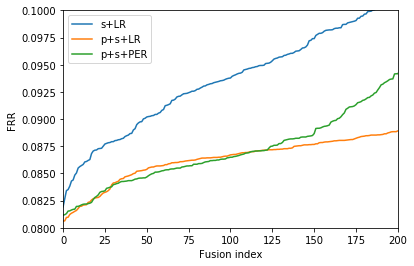

In [32]:
# Plot the best scores obtained by each method
pd.Series(score_lr).sort_values().reset_index(drop=True).plot(label='s+LR')
pd.Series(score_poly_lr).sort_values().reset_index(drop=True).plot(label='p+s+LR')
pd.Series(score_poly_per).sort_values().reset_index(drop=True).plot(label='p+s+PER')
plt.legend()
plt.xlim(0, 200)
plt.ylim(0.08, 0.10)
plt.xlabel('Fusion index')
plt.ylabel('FRR at 0.01% FAR')
plt.show()

In [123]:
# The best combinations for one method
pd.Series(score_poly_per).sort_values().head(10)

150    0.081166
159    0.081205
185    0.081303
192    0.081538
147    0.081558
191    0.081636
569    0.081695
101    0.081715
579    0.081969
102    0.081969
dtype: float64

In [ ]:
# The best combinations for each method
df_frr = pd.DataFrame(np.array([score_lr, score_poly_lr, score_poly_per]).T, columns=['s+LR', 'p+s+LR', 'p+s+PER'])
df_best = df_frr.apply(np.argsort)
df_best.head(10)

In [125]:
# The best "global" combinations
df_rank = df_frr.rank()
df_rank['mean'] = df_frr.mean(axis=1)
df_rank.sort_values(by='mean', inplace=True)
df_rank.head(20)

,s+LR,p+s+LR,p+s+PER,mean
147,2.0,1.0,5.0,0.081623
162,1.0,14.0,23.0,0.082433
96,5.0,9.0,16.0,0.082550
146,4.0,16.0,12.0,0.082654
159,11.0,5.0,2.0,0.082687
150,17.0,3.0,1.0,0.082798
111,3.0,4.0,53.0,0.083092
161,7.0,19.0,34.0,0.083725
108,42.0,2.0,14.5,0.083836
195,29.0,20.0,11.0,0.084201


Above, for each of the Top 20 combinations, see how each of the three methods ranked it, and the corresponding average FRR at 0.01% FAR. 

### Submission

For each member of the global Top 20, I submitted the matrix $M$ obtained by the 3 methods (60 submissions). The perceptron gave the best results (< 7% FRR) on a few combinations. 6.4% were obtained for a regularization parameter ('alpha') of 0.00001 on combination 195, i.e algorithms [7, 8, 9, 11, 13] (20 submissions). No better results were obtained by doing the following:
- using the perceptron's own Top 20, which confirms the interest of the "aggregation" strategy (20 submissions)
- not centering the data (only scaling it to unit variance) (20 submissions)
- applying other linear classifiers, e.g. passive aggressive classifier, linear SVM (not tested extensively).

In [160]:
#clf = LogisticRegression(class_weight='balanced', fit_intercept=False, tol=1e-7)
#clf = Perceptron(class_weight='balanced', fit_intercept=False, penalty='l1', alpha=1e-5, tol=1e-10, max_iter=1e5)
#clf = PassiveAggressiveClassifier(class_weight='balanced', fit_intercept=False, tol=1e-7)
#clf = SGDClassifier(class_weight='balanced', fit_intercept=False, loss='hinge',
#                    penalty='l1', alpha=1e-5, tol=1e-15, max_iter=1e9)
clf = LinearSVC(class_weight='balanced', fit_intercept=False, penalty='l1', dual=False, tol=1e-3, max_iter=1e3)


#lst_icombi = df_rank.index[:20]  # Global Top 20
#lst_icombi = df_best['p+s+PER'][:20]  # Specific Top 20
lst_icombi = [195]

for icombi in lst_icombi:
    row = lst_filtered_1[icombi]
    col = np.where(row)[0]

    x_trn = s_trn[:, row[1:]]
    s_trn_poly = poly.fit_transform(x_trn)
    s_trn_poly_scaled = scaler.fit_transform(s_trn_poly)
    s_trn_poly_scaled_1 = np.hstack(
        [np.ones((s_trn_poly_scaled.shape[0], 1)), s_trn_poly_scaled])
    clf.fit(s_trn_poly_scaled_1, y_trn)
    print("algorithms: {} ".format(col[1:]))
    score_func(y_trn, clf.decision_function(s_trn_poly_scaled_1))
    
    # Save fusion matrix
    M = construct_fusion_matrix(clf.coef_, col, scaler=scaler, poly=True)
    np.savetxt('M_pred_{}.txt'.format(icombi), M, fmt='%.18e')  # rather than '%f'


algorithms: [ 7  8  9 11 13] 
threshold: 1.8675305866818557 far: 9.961096661681113e-05 frr: 0.08249784600924258


### Generalization

The goal of this section is to try to find the best hyperparameters (loss, penalty, regularization parameter) of a linear classifier by cross-validation, for some of the best-ranked algorithm combinations (global Top 20). sklearn's SGDClassifier is convenient because it covers logistic regression, perceptron, and linear SVM. This is what we should do to have the best chance that the model works on new data; however, unfortunately, this effort does not translate into a better score on the test set.

In [72]:
#cv = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

my_scorer = make_scorer(score_func, greater_is_better=False,
                        needs_threshold=True, verbose=False)  # custom scorer

tuned_parameters = {'loss': ['log', 'hinge', 'perceptron'], 'alpha': [
    10 ** a for a in range(-8, -2)], 'penalty': ['l1', 'l2', 'elasticnet']}

clf = GridSearchCV(SGDClassifier(class_weight='balanced', fit_intercept=False, tol=1e-7,
                                 max_iter=1e3), tuned_parameters, cv=cv, n_jobs=-1, scoring=my_scorer, verbose=10)

#lst_icombi = df_rank.index[:20]  # Global Top 20
lst_icombi = [147]

for icombi in lst_icombi:
    row = lst_filtered_1[icombi]
    col = np.where(row)[0]
    
    x_trn = s_trn[:, row[1:]]
    s_trn_poly = poly.fit_transform(x_trn)
    s_trn_poly_scaled = scaler.fit_transform(s_trn_poly)
    s_trn_poly_scaled_1 = np.hstack(
        [np.ones((s_trn_poly_scaled.shape[0], 1)), s_trn_poly_scaled])
    
    clf.fit(s_trn_poly_scaled_1, y_trn)
    print("algorithms: {} ".format(col[1:]))
    print(clf.best_score_)
    print(clf.best_params_)
    
    # Save fusion matrix
    M = construct_fusion_matrix(clf.best_estimator_.coef_, col, scaler=scaler, poly=True)
    np.savetxt('M_pred_{}.txt'.format(icombi), M, fmt='%.18e')  # rather than '%f'


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 20.3min
[Paralle

algorithms: [ 7  9 12 13] 
-0.08010882640399837
{'alpha': 1e-05, 'loss': 'log', 'penalty': 'l2'}


If we consider running a perceptron on the winning combination [7, 8, 9, 11, 13], we do not find the parameters (penalty='l1', alpha=0.00001) which have given the best submission score (and the submission score is worse).

In [90]:
tuned_parameters = {'alpha': [10 ** a for a in range(-8, -2)], 'penalty': [
    'l1', 'l2']}

clf = GridSearchCV(Perceptron(class_weight='balanced',
                              fit_intercept=False, tol=1e-7, max_iter=1e3), tuned_parameters, cv=cv, n_jobs=-1, scoring=my_scorer, verbose=10)

for icombi in [195]:
    row = lst_filtered_1[icombi]
    col = np.where(row)[0]

    x_trn = s_trn[:, row[1:]]
    s_trn_poly = poly.fit_transform(x_trn)
    s_trn_poly_scaled = scaler.fit_transform(s_trn_poly)
    s_trn_poly_scaled_1 = np.hstack(
        [np.ones((s_trn_poly_scaled.shape[0], 1)), s_trn_poly_scaled])

    clf.fit(s_trn_poly_scaled_1, y_trn)
    print("algorithms: {} ".format(col[1:]))
    print(clf.best_score_)
    print(clf.best_params_)

    # Save fusion matrix
    M = construct_fusion_matrix(
        clf.best_estimator_.coef_, col, scaler=scaler, poly=True)
    np.savetxt('M_pred_{}.txt'.format(icombi), M, fmt='%.18e')  # rather than '%f'
    

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.0min finished


algorithms: [ 7  8  9 11 13] 
-0.08774582167271344
{'alpha': 1e-08, 'penalty': 'l1'}


## Conclusion

Ensemble learning could bring a potential improvement to this work: what we could do is identify a combination (preferably of a large number of algorithms, e.g. 5 or 6) such that: 1. it respects the computation time constraint, 2. it contains a set of subsets which, by majority voting of the classifiers trained on them, would give better results than using just one individually, as we have done in this study.

I also thought of this as a regression problem, where we would predict the minimum of the 14 scores for class 0, and the maximum of the 14 scores for class 1. The first results (linear regression, LASSO) were not good, but this may be worth spending some more time.

## Annexe

Making sure my $s'^\top M s'$ calculation works:

In [130]:
s = s_trn_1[:10, :]
fuse1 = np.sum(np.multiply(s, np.dot(s, M.T)), axis=1)  # efficient
fuse2 = np.sum(np.multiply(s[:, None, :] * s[:, :, None], M), axis=(1, 2))  # memory issue
np.allclose(fuse1, fuse2)

True

Not scaling the data is generally poor...

In [ ]:
clf = LogisticRegression(class_weight='balanced', fit_intercept=False)

score_combi1 = np.zeros((lst_filtered.shape[0],))

for icombi, combi in enumerate(lst_filtered):
    x_trn = s_trn[:, combi]
    s_trn_poly_scaled_1 = np.hstack(
        [np.ones((x_trn.shape[0], 1)), x_trn])
    clf.fit(s_trn_poly_scaled_1, y_trn)
    print("algorithms: {} ".format(np.where(combi)[0] + 1), end="")
    score_combi1[icombi] = score_func(y_trn, clf.decision_function(s_trn_poly_scaled_1))    


algorithms: [14] threshold: 3.762974962406707 far: 9.961096661681113e-05 frr: 0.1629787734001723
algorithms: [13] threshold: 4.695732338426765 far: 9.961096661681113e-05 frr: 0.1629787734001723
algorithms: [13 14] threshold: 6.626255676481566 far: 9.961096661681113e-05 frr: 0.1629787734001723
algorithms: [12] threshold: 5.084260796260271 far: 9.961096661681113e-05 frr: 0.312994438787499
algorithms: [12 14] threshold: 3.3180626581952675 far: 9.961096661681113e-05 frr: 0.1285149212814287
algorithms: [12 13] threshold: 3.5593258421825436 far: 9.961096661681113e-05 frr: 0.12673298347301637
algorithms: [12 13 14] threshold: 5.657476712311233 far: 9.961096661681113e-05 frr: 0.1299443878749902
algorithms: [11] threshold: 5.643333590750251 far: 9.961096661681113e-05 frr: 0.312994438787499
algorithms: [11 14] threshold: 3.970772698972784 far: 9.961096661681113e-05 frr: 0.1372287929819065
algorithms: [11 13] threshold: 3.807420753452872 far: 9.961096661681113e-05 frr: 0.12524477167697973
algorit

algorithms: [ 8 10 13] threshold: 3.501699077554342 far: 9.961096661681113e-05 frr: 0.10656379728988799
algorithms: [ 8 10 13 14] threshold: 5.45441636747362 far: 9.961096661681113e-05 frr: 0.12140675178193781
algorithms: [ 8 10 12] threshold: 3.023834134222426 far: 9.961096661681113e-05 frr: 0.09501057413644552
algorithms: [ 8 10 12 14] threshold: 2.6666469117948015 far: 9.961096661681113e-05 frr: 0.0916229341270463
algorithms: [ 8 10 12 13] threshold: 3.3232829261003793 far: 9.961096661681113e-05 frr: 0.09036970314091015
algorithms: [ 8 10 11] threshold: 3.411359140799565 far: 9.961096661681113e-05 frr: 0.10634839821414585
algorithms: [ 8 10 11 14] threshold: 3.2914229193190954 far: 9.961096661681113e-05 frr: 0.09833946894336963
algorithms: [ 8 10 11 13] threshold: 3.0932323960164636 far: 9.961096661681113e-05 frr: 0.1010025847889089
algorithms: [ 8 10 11 12] threshold: 4.497086196696525 far: 9.961096661681113e-05 frr: 0.12685047387796664
algorithms: [ 8 10 11 12 14] threshold: 4.194

algorithms: [ 7  9 10 12] threshold: 4.85191570429282 far: 9.961096661681113e-05 frr: 0.08941019816714968
algorithms: [ 7  9 10 12 14] threshold: 4.872835426615538 far: 9.961096661681113e-05 frr: 0.08854860186418109
algorithms: [ 7  9 10 12 13] threshold: 4.429293885077804 far: 9.961096661681113e-05 frr: 0.08570925041121642
algorithms: [ 7  9 10 11] threshold: 4.950743125017663 far: 9.961096661681113e-05 frr: 0.08617921203101747
algorithms: [ 7  9 10 11 14] threshold: 4.91042389008253 far: 9.961096661681113e-05 frr: 0.0845343463617138
algorithms: [ 7  9 10 11 13] threshold: 4.350320897102883 far: 9.961096661681113e-05 frr: 0.08226286519934205
algorithms: [ 7  9 10 11 12] threshold: 4.835349473700136 far: 9.961096661681113e-05 frr: 0.08676666405576879
algorithms: [7 8] threshold: 6.462317668065083 far: 9.961096661681113e-05 frr: 0.16534816323333595
algorithms: [ 7  8 14] threshold: 5.615228458364541 far: 9.961096661681113e-05 frr: 0.13135427273439335
algorithms: [ 7  8 13] threshold: 5.

algorithms: [ 5 10 13] threshold: 3.4692682388409626 far: 9.961096661681113e-05 frr: 0.12908279157202163
algorithms: [ 5 10 12] threshold: 3.399127504628906 far: 9.961096661681113e-05 frr: 0.10705334064384742
algorithms: [ 5 10 12 14] threshold: 2.9335660193420283 far: 9.961096661681113e-05 frr: 0.09755619957703454
algorithms: [ 5 10 12 13] threshold: 3.588335907890432 far: 9.961096661681113e-05 frr: 0.10000391634683167
algorithms: [ 5 10 11] threshold: 3.795683036650221 far: 9.961096661681113e-05 frr: 0.11823451084828072
algorithms: [ 5 10 11 14] threshold: 3.527374114201045 far: 9.961096661681113e-05 frr: 0.10666170596067988
algorithms: [ 5 10 11 13] threshold: 3.9396240032327476 far: 9.961096661681113e-05 frr: 0.10233414271167855
algorithms: [ 5 10 11 12] threshold: 4.497867933744548 far: 9.961096661681113e-05 frr: 0.1368567400328973
algorithms: [5 9] threshold: 3.463032418615928 far: 9.961096661681113e-05 frr: 0.13699381217200596
algorithms: [ 5  9 14] threshold: 3.440711744863732 

algorithms: [ 4  8  9 10] threshold: 5.0077229512679935 far: 9.961096661681113e-05 frr: 0.12309078091955823
algorithms: [ 4  8  9 10 12] threshold: 4.20734882766067 far: 9.961096661681113e-05 frr: 0.09473642985822825
algorithms: [ 4  8  9 10 11] threshold: 4.3891393841299475 far: 9.961096661681113e-05 frr: 0.08954727030625832
algorithms: [4 7] threshold: 4.4764355658357164 far: 9.961096661681113e-05 frr: 0.1685399859011514
algorithms: [ 4  7 14] threshold: 4.6209046941852385 far: 9.961096661681113e-05 frr: 0.13495731181953474
algorithms: [ 4  7 13] threshold: 4.749153337804771 far: 9.961096661681113e-05 frr: 0.1262630218532153
algorithms: [ 4  7 12] threshold: 3.3371800114395405 far: 9.961096661681113e-05 frr: 0.14092974073783973
algorithms: [ 4  7 12 14] threshold: 3.849303610128322 far: 9.961096661681113e-05 frr: 0.11846949165818124
algorithms: [ 4  7 12 13] threshold: 3.8227946465259013 far: 9.961096661681113e-05 frr: 0.11363280332106211
algorithms: [ 4  7 11] threshold: 3.368307157

algorithms: [ 4  5  8 10] threshold: 3.7708349089005235 far: 9.961096661681113e-05 frr: 0.12273830970470745
algorithms: [4 5 8 9] threshold: 4.0668673359317085 far: 9.961096661681113e-05 frr: 0.11985979478342602
algorithms: [4 5 7] threshold: 4.627718328366678 far: 9.961096661681113e-05 frr: 0.16315500900759772
algorithms: [ 4  5  7 12] threshold: 3.2663723783624903 far: 9.961096661681113e-05 frr: 0.1363476149447795
algorithms: [ 4  5  7 11] threshold: 3.41411145535169 far: 9.961096661681113e-05 frr: 0.13536852823686066
algorithms: [ 4  5  7 10] threshold: 4.273179268070026 far: 9.961096661681113e-05 frr: 0.12549933422103862
algorithms: [4 5 7 9] threshold: 4.210214226689304 far: 9.961096661681113e-05 frr: 0.11796036657006344
algorithms: [3] threshold: 3.8463044652072824 far: 9.961096661681113e-05 frr: 0.2558549385133547
algorithms: [ 3 14] threshold: 3.68399801981718 far: 9.961096661681113e-05 frr: 0.1688141301793687
algorithms: [ 3 13] threshold: 4.670623520617694 far: 9.961096661681

algorithms: [ 3  7 11 14] threshold: 3.649146866177028 far: 9.961096661681113e-05 frr: 0.11750998668442077
algorithms: [ 3  7 11 13] threshold: 4.369142410815684 far: 9.961096661681113e-05 frr: 0.11296702435967729
algorithms: [ 3  7 11 12] threshold: 5.356824002786357 far: 9.961096661681113e-05 frr: 0.1418305005091251
algorithms: [ 3  7 10] threshold: 3.511573141518334 far: 9.961096661681113e-05 frr: 0.12720294509281743
algorithms: [ 3  7 10 14] threshold: 3.2460346167110963 far: 9.961096661681113e-05 frr: 0.11294744262551891
algorithms: [ 3  7 10 13] threshold: 3.229185668776699 far: 9.961096661681113e-05 frr: 0.11911568888540769
algorithms: [ 3  7 10 12] threshold: 3.123809803020613 far: 9.961096661681113e-05 frr: 0.10002349808099005
algorithms: [ 3  7 10 11] threshold: 3.5465463156052532 far: 9.961096661681113e-05 frr: 0.10654421555572961
algorithms: [ 3  7 10 11 12] threshold: 4.865043797655324 far: 9.961096661681113e-05 frr: 0.11925276102451633
algorithms: [3 7 9] threshold: 4.049

algorithms: [ 3  4 12] threshold: 13.60549279607946 far: 9.961096661681113e-05 frr: 0.6556552048249393
algorithms: [ 3  4 11] threshold: 14.043837980371563 far: 9.961096661681113e-05 frr: 0.5953238818829796
algorithms: [ 3  4 11 12] threshold: 13.003625208911306 far: 9.961096661681113e-05 frr: 0.5160570220098692
algorithms: [ 3  4 10] threshold: 11.673871865776993 far: 9.961096661681113e-05 frr: 0.6020208349651445
algorithms: [ 3  4 10 12] threshold: 13.155080102862449 far: 9.961096661681113e-05 frr: 0.6756677371348007
algorithms: [ 3  4 10 11] threshold: 11.121885986202416 far: 9.961096661681113e-05 frr: 0.4647332967807629
algorithms: [3 4 9] threshold: 13.619489475467404 far: 9.961096661681113e-05 frr: 0.5908005012923945
algorithms: [ 3  4  9 12] threshold: 12.861507127258594 far: 9.961096661681113e-05 frr: 0.5964596224641654
algorithms: [ 3  4  9 11] threshold: 12.19380008985573 far: 9.961096661681113e-05 frr: 0.5086159630296859
algorithms: [ 3  4  9 10] threshold: 14.96826090673262

algorithms: [ 2  8 12 13] threshold: 4.644856053583563 far: 9.961096661681113e-05 frr: 0.11347614944779509
algorithms: [ 2  8 11] threshold: 3.665299922292874 far: 9.961096661681113e-05 frr: 0.15211091094227305
algorithms: [ 2  8 11 14] threshold: 3.3021210925974325 far: 9.961096661681113e-05 frr: 0.12452024751311976
algorithms: [ 2  8 11 13] threshold: 3.9770324325026927 far: 9.961096661681113e-05 frr: 0.11676588078640245
algorithms: [ 2  8 11 12] threshold: 4.7270640694970005 far: 9.961096661681113e-05 frr: 0.16305710033680582
algorithms: [ 2  8 10] threshold: 3.290511032082282 far: 9.961096661681113e-05 frr: 0.11890028980966555
algorithms: [ 2  8 10 14] threshold: 3.5623415647537637 far: 9.961096661681113e-05 frr: 0.11208584632255032
algorithms: [ 2  8 10 13] threshold: 4.0056392635681135 far: 9.961096661681113e-05 frr: 0.11028432677997964
algorithms: [ 2  8 10 12] threshold: 3.790921591872123 far: 9.961096661681113e-05 frr: 0.10070885877653325
algorithms: [ 2  8 10 11] threshold: 3

algorithms: [2 3 5] threshold: 4.266845182746593 far: 9.961096661681113e-05 frr: 0.23458917521735725
algorithms: [2 3 4] threshold: 8.492826803562462 far: 9.961096661681113e-05 frr: 0.39341662097595365
algorithms: [1] threshold: 4.142509549438955 far: 9.961096661681113e-05 frr: 0.25303516879454846
algorithms: [ 1 14] threshold: 3.48465848254164 far: 9.961096661681113e-05 frr: 0.15643847419127438
algorithms: [ 1 13] threshold: 4.5836353555991085 far: 9.961096661681113e-05 frr: 0.15896451789770502
algorithms: [ 1 13 14] threshold: 6.451326321799673 far: 9.961096661681113e-05 frr: 0.15857288321453747
algorithms: [ 1 12] threshold: 3.738283411952559 far: 9.961096661681113e-05 frr: 0.17325918383332028
algorithms: [ 1 12 14] threshold: 2.9930492211440862 far: 9.961096661681113e-05 frr: 0.1288478107621211
algorithms: [ 1 12 13] threshold: 3.3684327555192084 far: 9.961096661681113e-05 frr: 0.13470274927547585
algorithms: [ 1 12 13 14] threshold: 5.326417468458224 far: 9.961096661681113e-05 frr

algorithms: [1 7] threshold: 4.027079028007252 far: 9.961096661681113e-05 frr: 0.16536774496749432
algorithms: [ 1  7 14] threshold: 4.2479209049305755 far: 9.961096661681113e-05 frr: 0.127907887522519
algorithms: [ 1  7 13] threshold: 3.449270561819091 far: 9.961096661681113e-05 frr: 0.12624344011905694
algorithms: [ 1  7 12] threshold: 3.6138029796336983 far: 9.961096661681113e-05 frr: 0.1334495182893397
algorithms: [ 1  7 12 14] threshold: 3.3577039037335625 far: 9.961096661681113e-05 frr: 0.11451398135818908
algorithms: [ 1  7 12 13] threshold: 3.1715657490382414 far: 9.961096661681113e-05 frr: 0.1135544763844286
algorithms: [ 1  7 11] threshold: 3.864745969249169 far: 9.961096661681113e-05 frr: 0.13452651366805043
algorithms: [ 1  7 11 14] threshold: 4.072695339591842 far: 9.961096661681113e-05 frr: 0.11541474112947443
algorithms: [ 1  7 11 13] threshold: 3.318739435679838 far: 9.961096661681113e-05 frr: 0.11367196678937887
algorithms: [ 1  7 11 12] threshold: 5.425069939513836 fa

algorithms: [1 5 8 9] threshold: 3.49099447633873 far: 9.961096661681113e-05 frr: 0.11619801049580951
algorithms: [1 5 7] threshold: 3.650761107360422 far: 9.961096661681113e-05 frr: 0.16276337432443017
algorithms: [ 1  5  7 12] threshold: 3.9770996616523737 far: 9.961096661681113e-05 frr: 0.1320983786324117
algorithms: [ 1  5  7 11] threshold: 4.048338606488883 far: 9.961096661681113e-05 frr: 0.13299913840369704
algorithms: [ 1  5  7 10] threshold: 3.7116242498028935 far: 9.961096661681113e-05 frr: 0.1233845069319339
algorithms: [1 5 7 9] threshold: 3.391314836094682 far: 9.961096661681113e-05 frr: 0.11758831362105428
algorithms: [1 5 6] threshold: 48.51597988610406 far: 9.961096661681113e-05 frr: 0.9999216730633665
algorithms: [1 4] threshold: 3.713086431055679 far: 9.961096661681113e-05 frr: 0.25415132764157594
algorithms: [ 1  4 14] threshold: 3.5069904064461745 far: 9.961096661681113e-05 frr: 0.17803712696796428
algorithms: [ 1  4 13] threshold: 5.216433184387146 far: 9.9610966616

algorithms: [ 1  2  9 12] threshold: 16.701098578523762 far: 9.961096661681113e-05 frr: 0.873129944387875
algorithms: [ 1  2  9 11] threshold: 20.364244942886288 far: 9.961096661681113e-05 frr: 0.9654774026787812
algorithms: [ 1  2  9 11 12] threshold: 5.036225494776824 far: 9.961096661681113e-05 frr: 0.11010809117255424
algorithms: [ 1  2  9 10] threshold: 5.540042295178361 far: 9.961096661681113e-05 frr: 0.1581420850630532
algorithms: [ 1  2  9 10 12] threshold: 4.783844448935305 far: 9.961096661681113e-05 frr: 0.10215790710425315
algorithms: [ 1  2  9 10 11] threshold: 4.854487784358996 far: 9.961096661681113e-05 frr: 0.09788908905772695
algorithms: [1 2 8] threshold: 12.669799298545584 far: 9.961096661681113e-05 frr: 0.8097047074488917
algorithms: [ 1  2  8 12] threshold: 19.9263631240386 far: 9.961096661681113e-05 frr: 0.999843346126733
algorithms: [ 1  2  8 11] threshold: 16.18924280241467 far: 9.961096661681113e-05 frr: 0.8154421555572962
algorithms: [ 1  2  8 10] threshold: 20.

In [ ]:
clf = Perceptron(class_weight='balanced', fit_intercept=False, penalty='l1', tol=1e-10, max_iter=1e5)

score_combi2 = np.zeros((lst_filtered.shape[0],))

for icombi, combi in enumerate(lst_filtered):
    x_trn = s_trn[:, combi]
    s_trn_poly_scaled_1 = np.hstack(
        [np.ones((x_trn.shape[0], 1)), x_trn])
    clf.fit(s_trn_poly_scaled_1, y_trn)
    print("algorithms: {} ".format(np.where(combi)[0] + 1), end="")
    score_combi2[icombi] = score_func(y_trn, clf.decision_function(s_trn_poly_scaled_1))    


algorithms: [14] threshold: -41444.41649595788 far: 9.961096661681113e-05 frr: 0.1629787734001723
algorithms: [13] threshold: 284914735.63747907 far: 9.961096661681113e-05 frr: 0.1629787734001723
algorithms: [13 14] threshold: 1258838332.6386797 far: 9.961096661681113e-05 frr: 0.7425197775515
algorithms: [12] threshold: -6073831.296025582 far: 9.961096661681113e-05 frr: 0.9989230046212892
algorithms: [12 14] threshold: 765556818.1096041 far: 9.961096661681113e-05 frr: 0.39008772616902954
algorithms: [12 13] threshold: 210345705.4826129 far: 9.961096661681113e-05 frr: 0.9619331087961149
algorithms: [12 13 14] threshold: 2029234787.1354406 far: 9.961096661681113e-05 frr: 0.7499412547975248
algorithms: [11] threshold: 539667798.1106703 far: 9.961096661681113e-05 frr: 0.312994438787499
algorithms: [11 14] threshold: 238206595.0585517 far: 9.961096661681113e-05 frr: 0.965673220020365
algorithms: [11 13] threshold: 7164585.523135468 far: 9.961096661681113e-05 frr: 0.9984726247356466
algorith

algorithms: [ 7  9 10 12] threshold: 2343300474.6330295 far: 9.961096661681113e-05 frr: 0.9997846009242578
algorithms: [ 7  9 10 12 14] threshold: 3095045476.275015 far: 9.961096661681113e-05 frr: 0.9884663585807159
algorithms: [ 7  9 10 12 13] threshold: 2953415388.8160725 far: 9.961096661681113e-05 frr: 0.9932247199812015
algorithms: [ 7  9 10 11] threshold: 2367742889.70941 far: 9.961096661681113e-05 frr: 0.9879376517584397
algorithms: [ 7  9 10 11 14] threshold: 3167804071.7340775 far: 9.961096661681113e-05 frr: 0.9989425863554476
algorithms: [ 7  9 10 11 13] threshold: 3019383574.78385 far: 9.961096661681113e-05 frr: 0.9935184459935772
algorithms: [ 7  9 10 11 12] threshold: 2938488672.2900033 far: 9.961096661681113e-05 frr: 0.9478734236704003
algorithms: [7 8] threshold: 1417285163.8066142 far: 9.961096661681113e-05 frr: 0.7594579775984961
algorithms: [ 7  8 14] threshold: 2176795137.943591 far: 9.961096661681113e-05 frr: 0.7628456176078954
algorithms: [ 7  8 13] threshold: 21722

algorithms: [ 6  9 11 12] threshold: 6924402463.3531475 far: 9.961096661681113e-05 frr: 0.9999020913292082
algorithms: [ 6  9 10] threshold: 4061007533.0490074 far: 9.961096661681113e-05 frr: 0.9999216730633665
algorithms: [ 6  9 10 14] threshold: 6315051693.308556 far: 9.961096661681113e-05 frr: 0.9998629278608914
algorithms: [ 6  9 10 13] threshold: 8329419231.40526 far: 9.961096661681113e-05 frr: 0.9999020913292082
algorithms: [ 6  9 10 12] threshold: 7131883390.051003 far: 9.961096661681113e-05 frr: 0.9998825095950498
algorithms: [ 6  9 10 11] threshold: 7313360404.19531 far: 9.961096661681113e-05 frr: 0.9999020913292082
algorithms: [ 6  9 10 11 12] threshold: 8580716290.411108 far: 9.961096661681113e-05 frr: 0.9999020913292082
algorithms: [6 8] threshold: 2640564469.5890307 far: 9.961096661681113e-05 frr: 0.999843346126733
algorithms: [ 6  8 14] threshold: 7163110428.874481 far: 9.961096661681113e-05 frr: 0.9998629278608914
algorithms: [ 6  8 13] threshold: 5524487066.268806 far: 

algorithms: [ 5 10 12 14] threshold: 1376032875.4520113 far: 9.961096661681113e-05 frr: 0.3723466750215399
algorithms: [ 5 10 12 13] threshold: 860727253.3409165 far: 9.961096661681113e-05 frr: 0.8906751781937808
algorithms: [ 5 10 11] threshold: 388938420.9650517 far: 9.961096661681113e-05 frr: 0.9543549776768231
algorithms: [ 5 10 11 14] threshold: 548488797.1313093 far: 9.961096661681113e-05 frr: 0.9396882587921986
algorithms: [ 5 10 11 13] threshold: 949675707.3687192 far: 9.961096661681113e-05 frr: 0.8796506618626145
algorithms: [ 5 10 11 12] threshold: 733756302.2199726 far: 9.961096661681113e-05 frr: 0.3651993420537323
algorithms: [5 9] threshold: 729071725.699595 far: 9.961096661681113e-05 frr: 0.51568496906086
algorithms: [ 5  9 14] threshold: 1109112618.069132 far: 9.961096661681113e-05 frr: 0.4201065246338216
algorithms: [ 5  9 13] threshold: 601072383.476296 far: 9.961096661681113e-05 frr: 0.8146784679251194
algorithms: [ 5  9 12] threshold: 1826143738.33428 far: 9.96109666

algorithms: [ 5  6 14] threshold: 15150187125.830162 far: 9.961096661681113e-05 frr: 0.9998629278608914
algorithms: [ 5  6 13] threshold: 12304669029.248068 far: 9.961096661681113e-05 frr: 0.999843346126733
algorithms: [ 5  6 12] threshold: 14296927586.088602 far: 9.961096661681113e-05 frr: 0.9998629278608914
algorithms: [ 5  6 11] threshold: 13104787509.222706 far: 9.961096661681113e-05 frr: 0.9998629278608914
algorithms: [ 5  6 11 12] threshold: 19297855819.243164 far: 9.961096661681113e-05 frr: 0.9998629278608914
algorithms: [ 5  6 10] threshold: 14080806289.356403 far: 9.961096661681113e-05 frr: 0.999843346126733
algorithms: [ 5  6 10 12] threshold: 19841549996.886883 far: 9.961096661681113e-05 frr: 0.9998629278608914
algorithms: [ 5  6 10 11] threshold: 18764819734.973755 far: 9.961096661681113e-05 frr: 0.999843346126733
algorithms: [5 6 9] threshold: 13495325953.840254 far: 9.961096661681113e-05 frr: 0.999843346126733
algorithms: [ 5  6  9 12] threshold: 18737798998.855457 far: 9

algorithms: [ 4  7 14] threshold: 2992070865.6998763 far: 9.961096661681113e-05 frr: 0.999843346126733
algorithms: [ 4  7 13] threshold: 4304089896.281424 far: 9.961096661681113e-05 frr: 0.999843346126733
algorithms: [ 4  7 12] threshold: 3447961290.812566 far: 9.961096661681113e-05 frr: 0.9998629278608914
algorithms: [ 4  7 12 14] threshold: 4405243416.381993 far: 9.961096661681113e-05 frr: 0.9998629278608914
algorithms: [ 4  7 12 13] threshold: 5900380145.619711 far: 9.961096661681113e-05 frr: 0.9998041826584162
algorithms: [ 4  7 11] threshold: 2828591438.952495 far: 9.961096661681113e-05 frr: 0.9998629278608914
algorithms: [ 4  7 11 14] threshold: 3561149543.054762 far: 9.961096661681113e-05 frr: 0.9998629278608914
algorithms: [ 4  7 11 13] threshold: 5619795807.829 far: 9.961096661681113e-05 frr: 0.9998041826584162
algorithms: [ 4  7 11 12] threshold: 3307574336.3626213 far: 9.961096661681113e-05 frr: 0.9998825095950498
algorithms: [ 4  7 10] threshold: 2821072615.5991583 far: 9.9

algorithms: [ 3  7 10 13] threshold: 1081536681.497863 far: 9.961096661681113e-05 frr: 0.9811427900054829
algorithms: [ 3  7 10 12] threshold: 702767919.7622658 far: 9.961096661681113e-05 frr: 0.8007558549385133
algorithms: [ 3  7 10 11] threshold: 692333388.0322641 far: 9.961096661681113e-05 frr: 0.7985235372444583
algorithms: [ 3  7 10 11 12] threshold: 1033987596.0356623 far: 9.961096661681113e-05 frr: 0.7235842406203493
algorithms: [3 7 9] threshold: 6384011.585960446 far: 9.961096661681113e-05 frr: 0.9966319417247591
algorithms: [ 3  7  9 14] threshold: 690181127.7062838 far: 9.961096661681113e-05 frr: 0.9998237643925746
algorithms: [ 3  7  9 13] threshold: 725940624.594677 far: 9.961096661681113e-05 frr: 0.9714302498629278
algorithms: [ 3  7  9 12] threshold: 19552215.793595873 far: 9.961096661681113e-05 frr: 0.9999608365316832
algorithms: [ 3  7  9 11] threshold: 1256962269.7033603 far: 9.961096661681113e-05 frr: 0.2874990209132921
algorithms: [ 3  7  9 11 12] threshold: 7967624

algorithms: [ 2  8 10 14] threshold: 1883572651.7602787 far: 9.961096661681113e-05 frr: 0.9931072295762513
algorithms: [ 2  8 10 13] threshold: 3202524698.4760113 far: 9.961096661681113e-05 frr: 0.9999216730633665
algorithms: [ 2  8 10 12] threshold: 1834519191.2249112 far: 9.961096661681113e-05 frr: 0.8132294195973996
algorithms: [ 2  8 10 11] threshold: 1713177966.527224 far: 9.961096661681113e-05 frr: 0.904911098926921
algorithms: [ 2  8 10 11 12] threshold: 2024507263.0963356 far: 9.961096661681113e-05 frr: 0.9960640714341662
algorithms: [2 8 9] threshold: 1875837972.0082645 far: 9.961096661681113e-05 frr: 0.9999216730633665
algorithms: [ 2  8  9 14] threshold: 2844657975.25738 far: 9.961096661681113e-05 frr: 0.9998629278608914
algorithms: [ 2  8  9 13] threshold: 3393244303.8918586 far: 9.961096661681113e-05 frr: 0.9999020913292082
algorithms: [ 2  8  9 12] threshold: 3083859022.97483 far: 9.961096661681113e-05 frr: 0.9998629278608914
algorithms: [ 2  8  9 11] threshold: 252527561

algorithms: [ 2  5 12] threshold: 4838721683.75344 far: 9.961096661681113e-05 frr: 0.9998629278608914
algorithms: [ 2  5 11] threshold: 3783977999.01017 far: 9.961096661681113e-05 frr: 0.999843346126733
algorithms: [ 2  5 11 12] threshold: 2879732418.2195563 far: 9.961096661681113e-05 frr: 0.9997650191900995
algorithms: [ 2  5 10] threshold: 4049778992.5771465 far: 9.961096661681113e-05 frr: 0.9999020913292082
algorithms: [ 2  5 10 12] threshold: 6603744129.774822 far: 9.961096661681113e-05 frr: 0.9998629278608914
algorithms: [ 2  5 10 11] threshold: 5030843782.433764 far: 9.961096661681113e-05 frr: 0.999843346126733
algorithms: [2 5 9] threshold: 4531379713.156416 far: 9.961096661681113e-05 frr: 0.9998825095950498
algorithms: [ 2  5  9 12] threshold: 6947452587.102113 far: 9.961096661681113e-05 frr: 0.9998825095950498
algorithms: [ 2  5  9 11] threshold: 5202119827.918205 far: 9.961096661681113e-05 frr: 0.9998629278608914
algorithms: [ 2  5  9 10] threshold: 2764472981.799452 far: 9.9